In [4]:
'''
This script is demo for one-one corresponding dataset with
CCA-zoo implemented MCCA, to estimate the PI
'''
import numpy as np
import matplotlib.pyplot as plt

In [5]:
'''
This part is essential to test the Python and MATLAB callability.
To apply the fmincon function in MATLAB to solve the minimization problem.
'''
import matlab
import matlab.engine

########################
mat_eng = matlab.engine.start_matlab()

In [4]:
# # generate the Synthetic data from matlab
# n = 20
# d = 7
# dx = 10
# dy = 15

# X, Y_init, Sx, Sy, S  = mat_eng.gen_cca_data(n, d, dx, dy, nargout=5)

# print("# the X is : ", np.array(X).shape)
# print("# the Y is : ", np.array(Y_init).shape)
# print("# the Sx is : ")
# print(np.array(Sx).shape)
# print("# the Sy is : ")
# print(np.array(Sy).shape)
# print("# S is : ")
# print(np.array(S).shape)

In [6]:
##########################################
#      Import Wiki Embeddings dataset     #
##########################################
'''Print the content of the Wiki_embeddings file'''
with open('/Users/cbq/Downloads/ACCA/Wiki_embeddings/wiki_dw16.txt', 'r') as file:
    '''print each line of the file along with its line number'''
    for line_num, line in enumerate(file, 1):
        print(f"Line {line_num}: {line.strip()}")
'''Loading the dataset by excluding the Line 1 to elimate the problem of mismatch.
    Due to the dataset is space-separated, delimiter is set to be 'space' '''
df = np.loadtxt('/Users/cbq/Downloads/ACCA/Wiki_embeddings/wiki_dw16.txt', delimiter = ' ', skiprows = 1)


Line 1: 2405 16
Line 2: 1397 -0.04649586 -0.592263 0.193041 -0.8715965 0.30907896 -0.06527032 -0.09717362 -0.18356244 -0.105479166 0.17375366 0.2527356 0.8272254 -0.022462722 0.19558588 -0.28256443 -0.3771691
Line 3: 1470 0.17321905 -0.57178134 0.32271746 -0.252033 0.34215954 -0.34100214 -0.059800252 -0.4623868 -0.015906667 0.37253407 0.1865815 0.7352984 -0.05550039 0.22226605 -0.04914893 -0.62170225
Line 4: 362 -0.082836814 -1.114098 0.26671398 -0.93568826 0.22014916 0.019924166 -0.31055406 -0.1692034 -0.59047997 0.12763335 0.34064445 0.8103196 0.023961527 0.2813633 -0.4096681 -0.7087515
Line 5: 226 -0.13495964 -0.612187 -0.17446253 -0.46283442 0.87310547 -0.51826096 -0.37305132 -0.4166855 0.25383338 -0.29254106 0.1729277 1.132911 0.32083246 -0.024495156 -0.31444013 0.07424098
Line 6: 750 0.27021232 -0.49792844 0.49040455 -0.66774553 0.19874325 -0.066587016 0.43943882 -0.23604578 0.17299758 0.47523758 0.2668194 0.45369366 0.098503605 0.25488237 -0.23607524 -0.71465445
Line 7: 489 0.16

In [2]:
# #################################
# #      Generate the dataset     #
# #################################
# import random

# # randomize the order of data samples in Y
# Y_order = np.array(random.sample(range(n), n))
# # re-ordered dataset Y
# Y = np.zeros((np.array(Y_init).shape[0], np.array(Y_init).shape[1]))

# true_PI = np.zeros((n, n))
# for i in range(len(Y_order)):
#     Y_i = int(Y_order[i])
#     Y[i] = np.array(Y_init)[Y_i]
#     # generate the groundtruth PI
#     true_PI[i][Y_i] = 1

# # reshape the X, Y datasets and permutation matrix
# X = np.array(X).T
# Y = Y.T
# true_PI = true_PI.T

# print(X.shape)
# print(Y.shape)
# print(true_PI.shape)

In [7]:
#################################
#    Function for MAXVAR MCCA   #
#################################

from cca_zoo.utils.check_values import _process_parameter
from heapq import nlargest

def MAXVAR_MCCA(X, Y, PI):
    '''
    update the projections by Max-of-Variance MCCA
    input: X --> the first dataset
           Y --> the second dataset
           PI --> the estimated permutation matrix
    Output: U --> the projection matrix for dataset X
            V --> the projection matrix for dataset Y
            S --> the common resource matrix
    '''
    # common termed to be used
    YPI = np.dot(Y, PI)
    XXT_inv = np.linalg.inv(np.dot(X, X.T))
    YPI_YPIT_inv = np.linalg.inv(np.dot(YPI, YPI.T))
    
    # estimate the common resource matrix S
    f_1 = np.dot(X.T, np.dot(XXT_inv, X))
    f_2 = np.dot(YPI.T, np.dot(YPI_YPIT_inv, YPI))
    f = f_1 + f_2
    # Compute the Eigenvectors and eigenvalues for function f, as complex numbers
    eigenvalues, eigenvectors = np.linalg.eig(f)
    # only takes the real part of the complex numbers
    eigenvalues = eigenvalues.real.tolist()
    eigenvectors = eigenvectors.real
    # the first d columns of eigenvectors should be the values of S
    largest_eigen = nlargest(latent_dims, eigenvalues)
    S = []
    for principal_eigenvalue in largest_eigen:
        eigen_idx = eigenvalues.index(principal_eigenvalue)
        eigen_vec = eigenvectors[eigen_idx]
        S.append(eigen_vec)
    # convert the S matrix into array
    S = np.array(S)
    
    # estimate the projections U and V
    U = np.dot(XXT_inv, np.dot(X, S.T))
    V = np.dot(YPI_YPIT_inv, np.dot(YPI, S.T))
    
    return U, V, S

In [ ]:
#########################################
#         Function to update PI         #
#########################################
from scipy.optimize import minimize
from scipy.stats import entropy
from scipy.optimize import Bounds
import scipy
from scipy.spatial import procrustes

from pathlib import Path
from iodata import load_one
from iodata.utils import angstrom
from procrustes import rotational


# fro_loss_list = []

# def optimize_PI(PI, X, Y, U, V, S, n, \
#                lambda_1 = 0.0001, \
#                lambda_2 = 0.0001, \
#                entropy_threshold = 1e-3):
#     '''
#     update the projections by Max-of-Variance MCCA
#     input: X --> the first dataset
#            Y --> the second dataset
           
#            U --> the projection matrix for dataset X
#            V --> the projection matrix for dataset Y
#            S --> the common resource matrix
#     Output: PI --> the estimated permutation matrix
#     '''
    
#     # compute the matrix for the  minimization
#     YTV = np.dot(Y.T, V)
#     YTVVTY = np.dot(YTV, YTV.T)
#     YTVS = np.dot(np.dot(Y.T, V), S)
    
#     # the miminizer for the permutation
#     def objective(PI):
#         PI = PI.reshape(n, n)
#         return np.linalg.norm(np.dot(YTVVTY, PI) - YTVS, "fro") + \
#                lambda_1*np.linalg.norm((np.dot(PI, PI.T) - np.identity(n)), "fro") + \
#                lambda_2*np.linalg.norm((np.dot(PI.T, PI) - np.identity(n)), "fro") # Minimize the F norm

#     # subject to Pi * 1 = 1
#     def one_vec_cons_1(PI):
#         one_vec = np.ones(n)
#         PI = PI.reshape(n, n)
#         return np.dot(PI, one_vec) - one_vec
    
#     # subject to 1 * Pi = 1
#     def one_vec_cons_2(PI):
#         one_vec = np.ones(n)
#         PI = PI.reshape(n, n)
#         return np.dot(PI.T, one_vec.T) - one_vec
    
#     # subject to 0 <= Pi <= 1
#     def entropy_cons(PI):
#         PI = PI.reshape(n, n)
#         #set entropy row-wise
#         row_entropies = np.sum(scipy.stats.entropy(PI.reshape(n*n), base=10))
#         return entropy_threshold - row_entropies
    
#     # set the value range boundary for the PI elements
#     value_bounds = Bounds(0.0, 1.0)
#     constraints_list = ({'type': 'eq', 'fun': one_vec_cons_1}, 
#                         {'type': 'eq', 'fun': one_vec_cons_2},
#                         {'type': 'ineq', 'fun': entropy_cons})
#     # Formulate the optimization problem
#     PI = PI.reshape(n*n)
#     # Modify the minimize function call to include the bounds
#     problem = minimize(objective, PI, bounds=value_bounds, constraints=constraints_list, options={'maxiter':8})

#     return problem.x
    

In [ ]:
###################################################
#    generate the training and testing dataset    #
###################################################
from heapq import nlargest
import time
import copy

# the total training iterations
train_epoch = 10
# the learning rate
lr = 0.0001
latent_dims = d

fro_norm_list = []
PI_norm_list = []
CCA_loss_list= []
# record the initial error and accuracy
# fro_norm = np.linalg.norm(true_PI - esti_PI, "fro")
# fro_norm_list.append(fro_norm)

for i in range(train_epoch): 
    ## update Permutation with datasets (X, Y), and fixed (U, V, S)
    t_PI = time.time()
    if i > 0:
        esti_PI = optimize_PI(esti_PI, X, Y, U, V, S, n).reshape(n, n)
    else:
        esti_PI = copy.deepcopy(true_PI)
        # initialize the PI at totally random
        for j in range(int(n)):
            esti_PI[j] = np.random.dirichlet(np.ones(n),size=1)[0]
    t_PI = time.time() - t_PI
    print("# iter=", i, ", Permutation part time-cost = ", t_PI)
    ## update the projections with datasets (X, Y), and fixed permutation PI
    # train with the input as: (X, PI*Y)
    t_CCA = time.time()
    U, V, S = MAXVAR_MCCA(X, Y, esti_PI)
    t_CCA = time.time() - t_CCA
    print("# iter=", i, ", CCA part time-cost = ", t_CCA)
    # compute the error of permutation estimation
    YTV = np.dot(Y.T, V)
    YTVVTY = np.dot(YTV, YTV.T)
    YTVS = np.dot(np.dot(Y.T, V), S)
    print("### main norm = ", np.linalg.norm(np.dot(YTVVTY, esti_PI) - YTVS, "fro"))
    fro_loss_list.append(np.linalg.norm(np.dot(YTVVTY, esti_PI) - YTVS, "fro"))
    fro_norm = np.linalg.norm(true_PI - esti_PI, "fro")
    fro_norm_list.append(fro_norm)
    # calculate || PI.T*PI - I || loss
    PI_norm = np.linalg.norm((np.dot(esti_PI, esti_PI.T) - np.identity(n)), "fro") \
              + np.linalg.norm((np.dot(esti_PI.T, esti_PI) - np.identity(n)), "fro")
    PI_norm_list.append(PI_norm)
    print("# PI norm is : ", PI_norm)
    # calculate the CCA loss: UX - VY*PI
    if i == 0:
        init_CCA_loss = np.linalg.norm(np.dot(U.T, X) - np.dot(V.T, np.dot(Y, true_PI)), "fro")
    else:
        CCA_loss_curr = np.linalg.norm(np.dot(U.T, X) - np.dot(V.T, np.dot(Y, true_PI)), "fro")
        CCA_loss = abs(init_CCA_loss - CCA_loss_curr)
    if i > 0:
        CCA_loss_list.append(CCA_loss)
        print("# CCA norm is : ", CCA_loss)
    
#     print("Estimated PI matrice: ")
#     print(esti_PI)
    print("U matrix: ")
    print(U)
    print("V matrix: ")
    print(V)
    print("S matrix: ")
    print(S)
    
    print()
    
    print("# iter=", i, ", the error = ", fro_norm)


# iter= 0 , Permutation part time-cost =  0.0014011859893798828
# iter= 0 , CCA part time-cost =  0.005911111831665039
### main norm =  7.6150007696215
# PI norm is :  8.359048185611739
U matrix: 
[[-9.59674761e-01  4.73843427e+00  4.73843427e+00  5.83891992e+00
  -1.11406333e+01  3.68985220e+00 -5.21640701e-03]
 [-1.80306807e+00 -1.94654942e+00 -1.94654942e+00 -5.45294899e+00
   1.17883879e+01 -4.01967741e-01 -1.31644709e-01]
 [-2.97481994e+00  6.94333046e+00  6.94333046e+00  5.90667735e+00
  -1.03626428e+01  6.83494452e+00 -3.64000703e-02]
 [ 2.09291990e+00  2.70511749e+00  2.70511749e+00 -1.12200029e+00
   1.54229708e+00  5.78226120e+00  9.27730583e-01]
 [ 2.13933039e+00 -3.08724244e+00 -3.08724244e+00 -4.16438092e+00
   7.52085459e+00 -1.86033102e+00  3.32065068e-01]
 [-3.49427762e+00  9.33247770e-01  9.33247770e-01  4.41381179e+00
  -7.57600770e+00 -2.36740789e+00 -9.79866893e-01]
 [ 6.58846781e+00 -3.79749048e+00 -3.79749048e+00 -6.54595173e+00
   1.02514316e+01  1.93292697e-01  

# iter= 2 , Permutation part time-cost =  6.897103786468506
# iter= 2 , CCA part time-cost =  0.00044083595275878906
### main norm =  1.5568082590438397
# PI norm is :  3.674558490602789
# CCA norm is :  13.14876619130569
U matrix: 
[[-5.23470262  7.71472469  3.48161557  3.48161557 -5.91969249  7.05491521
  -5.9470174 ]
 [ 4.53890687 -7.78093355 -1.86053382 -1.86053382  3.36961026 -6.16329607
   2.57266095]
 [-5.5349928   7.32562157  5.08726764  5.08726764 -7.83809412  8.12554267
  -8.58476307]
 [ 2.33567273 -0.28390721  4.4907815   4.4907815   0.01201827  8.18519383
   0.54785029]
 [ 4.3640929  -4.97554539 -1.48072414 -1.48072414  4.66194671 -2.31705874
   5.13666683]
 [-5.4547967   4.57334466 -1.81971965 -1.81971965 -4.24684697 -3.66746963
  -4.96338827]
 [ 8.11082022 -6.49219875  0.82182679  0.82182679  7.86579669  3.32007218
   9.43067525]
 [-0.77645714 -0.06852475  0.85251301  0.85251301 -2.00326482 -0.102302
  -2.66590897]
 [-3.1927942   1.04457716 -0.52234082 -0.52234082 -3.7724

# iter= 4 , Permutation part time-cost =  1.157196044921875
# iter= 4 , CCA part time-cost =  0.0004811286926269531
### main norm =  1.4548713844336891
# PI norm is :  3.6745582124423866
# CCA norm is :  13.601215708574092
U matrix: 
[[ 2.52185652  3.28229699  3.28229699 -2.55521283 -2.55521283  0.87306024
  -2.98573877]
 [-5.81747044 -4.0976634  -4.0976634   2.03365016  2.03365016 -1.67005277
   3.35729055]
 [-0.08886267  2.40715365  2.40715365 -3.11891179 -3.11891179  0.06383315
  -2.75179787]
 [ 0.43528096 -2.40055317 -2.40055317 -3.20992783 -3.20992783 -2.53798653
  -0.70455227]
 [-0.5368486  -2.56657937 -2.56657937  0.85406543  0.85406543 -1.0664831
   1.62335316]
 [-0.02912241  3.86315064  3.86315064  1.47566588  1.47566588  2.6832355
  -0.90970438]
 [ 2.1773111  -4.67145134 -4.67145134 -1.31260038 -1.31260038 -2.98623265
   1.16140365]
 [-2.58667206 -0.40447625 -0.40447625 -0.08882819 -0.08882819 -0.3365954
   0.3197211 ]
 [-3.53567426  1.07328132  1.07328132  1.15548499  1.1554

# iter= 6 , Permutation part time-cost =  1.1846599578857422
# iter= 6 , CCA part time-cost =  0.0005838871002197266
### main norm =  1.4548713844336891
# PI norm is :  3.6745582124423866
# CCA norm is :  13.601215708574092
U matrix: 
[[ 2.52185652  3.28229699  3.28229699 -2.55521283 -2.55521283  0.87306024
  -2.98573877]
 [-5.81747044 -4.0976634  -4.0976634   2.03365016  2.03365016 -1.67005277
   3.35729055]
 [-0.08886267  2.40715365  2.40715365 -3.11891179 -3.11891179  0.06383315
  -2.75179787]
 [ 0.43528096 -2.40055317 -2.40055317 -3.20992783 -3.20992783 -2.53798653
  -0.70455227]
 [-0.5368486  -2.56657937 -2.56657937  0.85406543  0.85406543 -1.0664831
   1.62335316]
 [-0.02912241  3.86315064  3.86315064  1.47566588  1.47566588  2.6832355
  -0.90970438]
 [ 2.1773111  -4.67145134 -4.67145134 -1.31260038 -1.31260038 -2.98623265
   1.16140365]
 [-2.58667206 -0.40447625 -0.40447625 -0.08882819 -0.08882819 -0.3365954
   0.3197211 ]
 [-3.53567426  1.07328132  1.07328132  1.15548499  1.155

# iter= 8 , Permutation part time-cost =  1.176537036895752
# iter= 8 , CCA part time-cost =  0.0004990100860595703
### main norm =  1.4548713844336891
# PI norm is :  3.6745582124423866
# CCA norm is :  13.601215708574092
U matrix: 
[[ 2.52185652  3.28229699  3.28229699 -2.55521283 -2.55521283  0.87306024
  -2.98573877]
 [-5.81747044 -4.0976634  -4.0976634   2.03365016  2.03365016 -1.67005277
   3.35729055]
 [-0.08886267  2.40715365  2.40715365 -3.11891179 -3.11891179  0.06383315
  -2.75179787]
 [ 0.43528096 -2.40055317 -2.40055317 -3.20992783 -3.20992783 -2.53798653
  -0.70455227]
 [-0.5368486  -2.56657937 -2.56657937  0.85406543  0.85406543 -1.0664831
   1.62335316]
 [-0.02912241  3.86315064  3.86315064  1.47566588  1.47566588  2.6832355
  -0.90970438]
 [ 2.1773111  -4.67145134 -4.67145134 -1.31260038 -1.31260038 -2.98623265
   1.16140365]
 [-2.58667206 -0.40447625 -0.40447625 -0.08882819 -0.08882819 -0.3365954
   0.3197211 ]
 [-3.53567426  1.07328132  1.07328132  1.15548499  1.1554

In [ ]:
YTV = np.dot(Y.T, V)
YTVVTY = np.dot(YTV, YTV.T)
YTVS = np.dot(np.dot(Y.T, V), S)
    
print(np.linalg.norm(np.dot(YTVVTY, esti_PI) - YTVS, "fro"))

print(np.linalg.norm(np.dot(esti_PI, esti_PI.T)-np.identity(n), "fro"))
print(np.linalg.norm(np.dot(esti_PI.T, esti_PI)-np.identity(n), "fro"))

1.4548713844336891
1.8372791062211933
1.837279106221193


In [ ]:
# Using top-K methods to take any one of the top k permutions into account for computing accuracy
k_list = [i+1 for i in range(n)] # change k to desired value for top-k accuracy

for k in k_list:
    acc = 0.0
    for i in range(len(true_PI)):
    #     pred = np.argmax(esti_PI[i])
        pred = np.argsort(esti_PI[i])[-k:]
        label = np.argmax(true_PI[i])
        if np.any(pred == label):
            acc += 1
    acc = acc / n
    print("For top-", k," evaluation, Accuracy = ", acc)

For top- 1  evaluation, Accuracy =  0.05
For top- 2  evaluation, Accuracy =  0.05
For top- 3  evaluation, Accuracy =  0.15
For top- 4  evaluation, Accuracy =  0.3
For top- 5  evaluation, Accuracy =  0.3
For top- 6  evaluation, Accuracy =  0.45
For top- 7  evaluation, Accuracy =  0.5
For top- 8  evaluation, Accuracy =  0.55
For top- 9  evaluation, Accuracy =  0.6
For top- 10  evaluation, Accuracy =  0.65
For top- 11  evaluation, Accuracy =  0.65
For top- 12  evaluation, Accuracy =  0.7
For top- 13  evaluation, Accuracy =  0.8
For top- 14  evaluation, Accuracy =  0.8
For top- 15  evaluation, Accuracy =  0.85
For top- 16  evaluation, Accuracy =  0.9
For top- 17  evaluation, Accuracy =  0.9
For top- 18  evaluation, Accuracy =  0.9
For top- 19  evaluation, Accuracy =  0.95
For top- 20  evaluation, Accuracy =  1.0


In [ ]:
true_PI

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.

In [ ]:
esti_PI

array([[5.06505587e-12, 0.00000000e+00, 3.40814967e-01, 8.83868682e-02,
        2.65274930e-12, 0.00000000e+00, 4.28335760e-12, 4.35222695e-12,
        7.62542816e-13, 2.60357962e-12, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 3.24680747e-12, 0.00000000e+00, 0.00000000e+00,
        1.22512321e-12, 0.00000000e+00, 0.00000000e+00, 5.70798189e-01],
       [1.97114870e-01, 9.69775079e-14, 3.37702547e-13, 9.45331000e-13,
        1.52108050e-13, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 7.72659299e-13, 8.02885166e-01,
        1.77189221e-12, 9.54355251e-13, 9.46013052e-13, 4.19942892e-13,
        0.00000000e+00, 6.95853550e-12, 2.32378602e-13, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.32281034e-12,
        0.00000000e+00, 1.96458443e-01, 0.00000000e+00, 4.11429443e-12,
        3.25904676e-12, 8.03541580e-01, 3.30801870e-12, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 9.85615841e-12, 8.8670

In [ ]:
import torchvision.transforms as transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

plt.imsave("true_PI.png", true_PI, cmap='Greys')
plt.imsave("esti_PI.png", esti_PI, cmap='Greys')

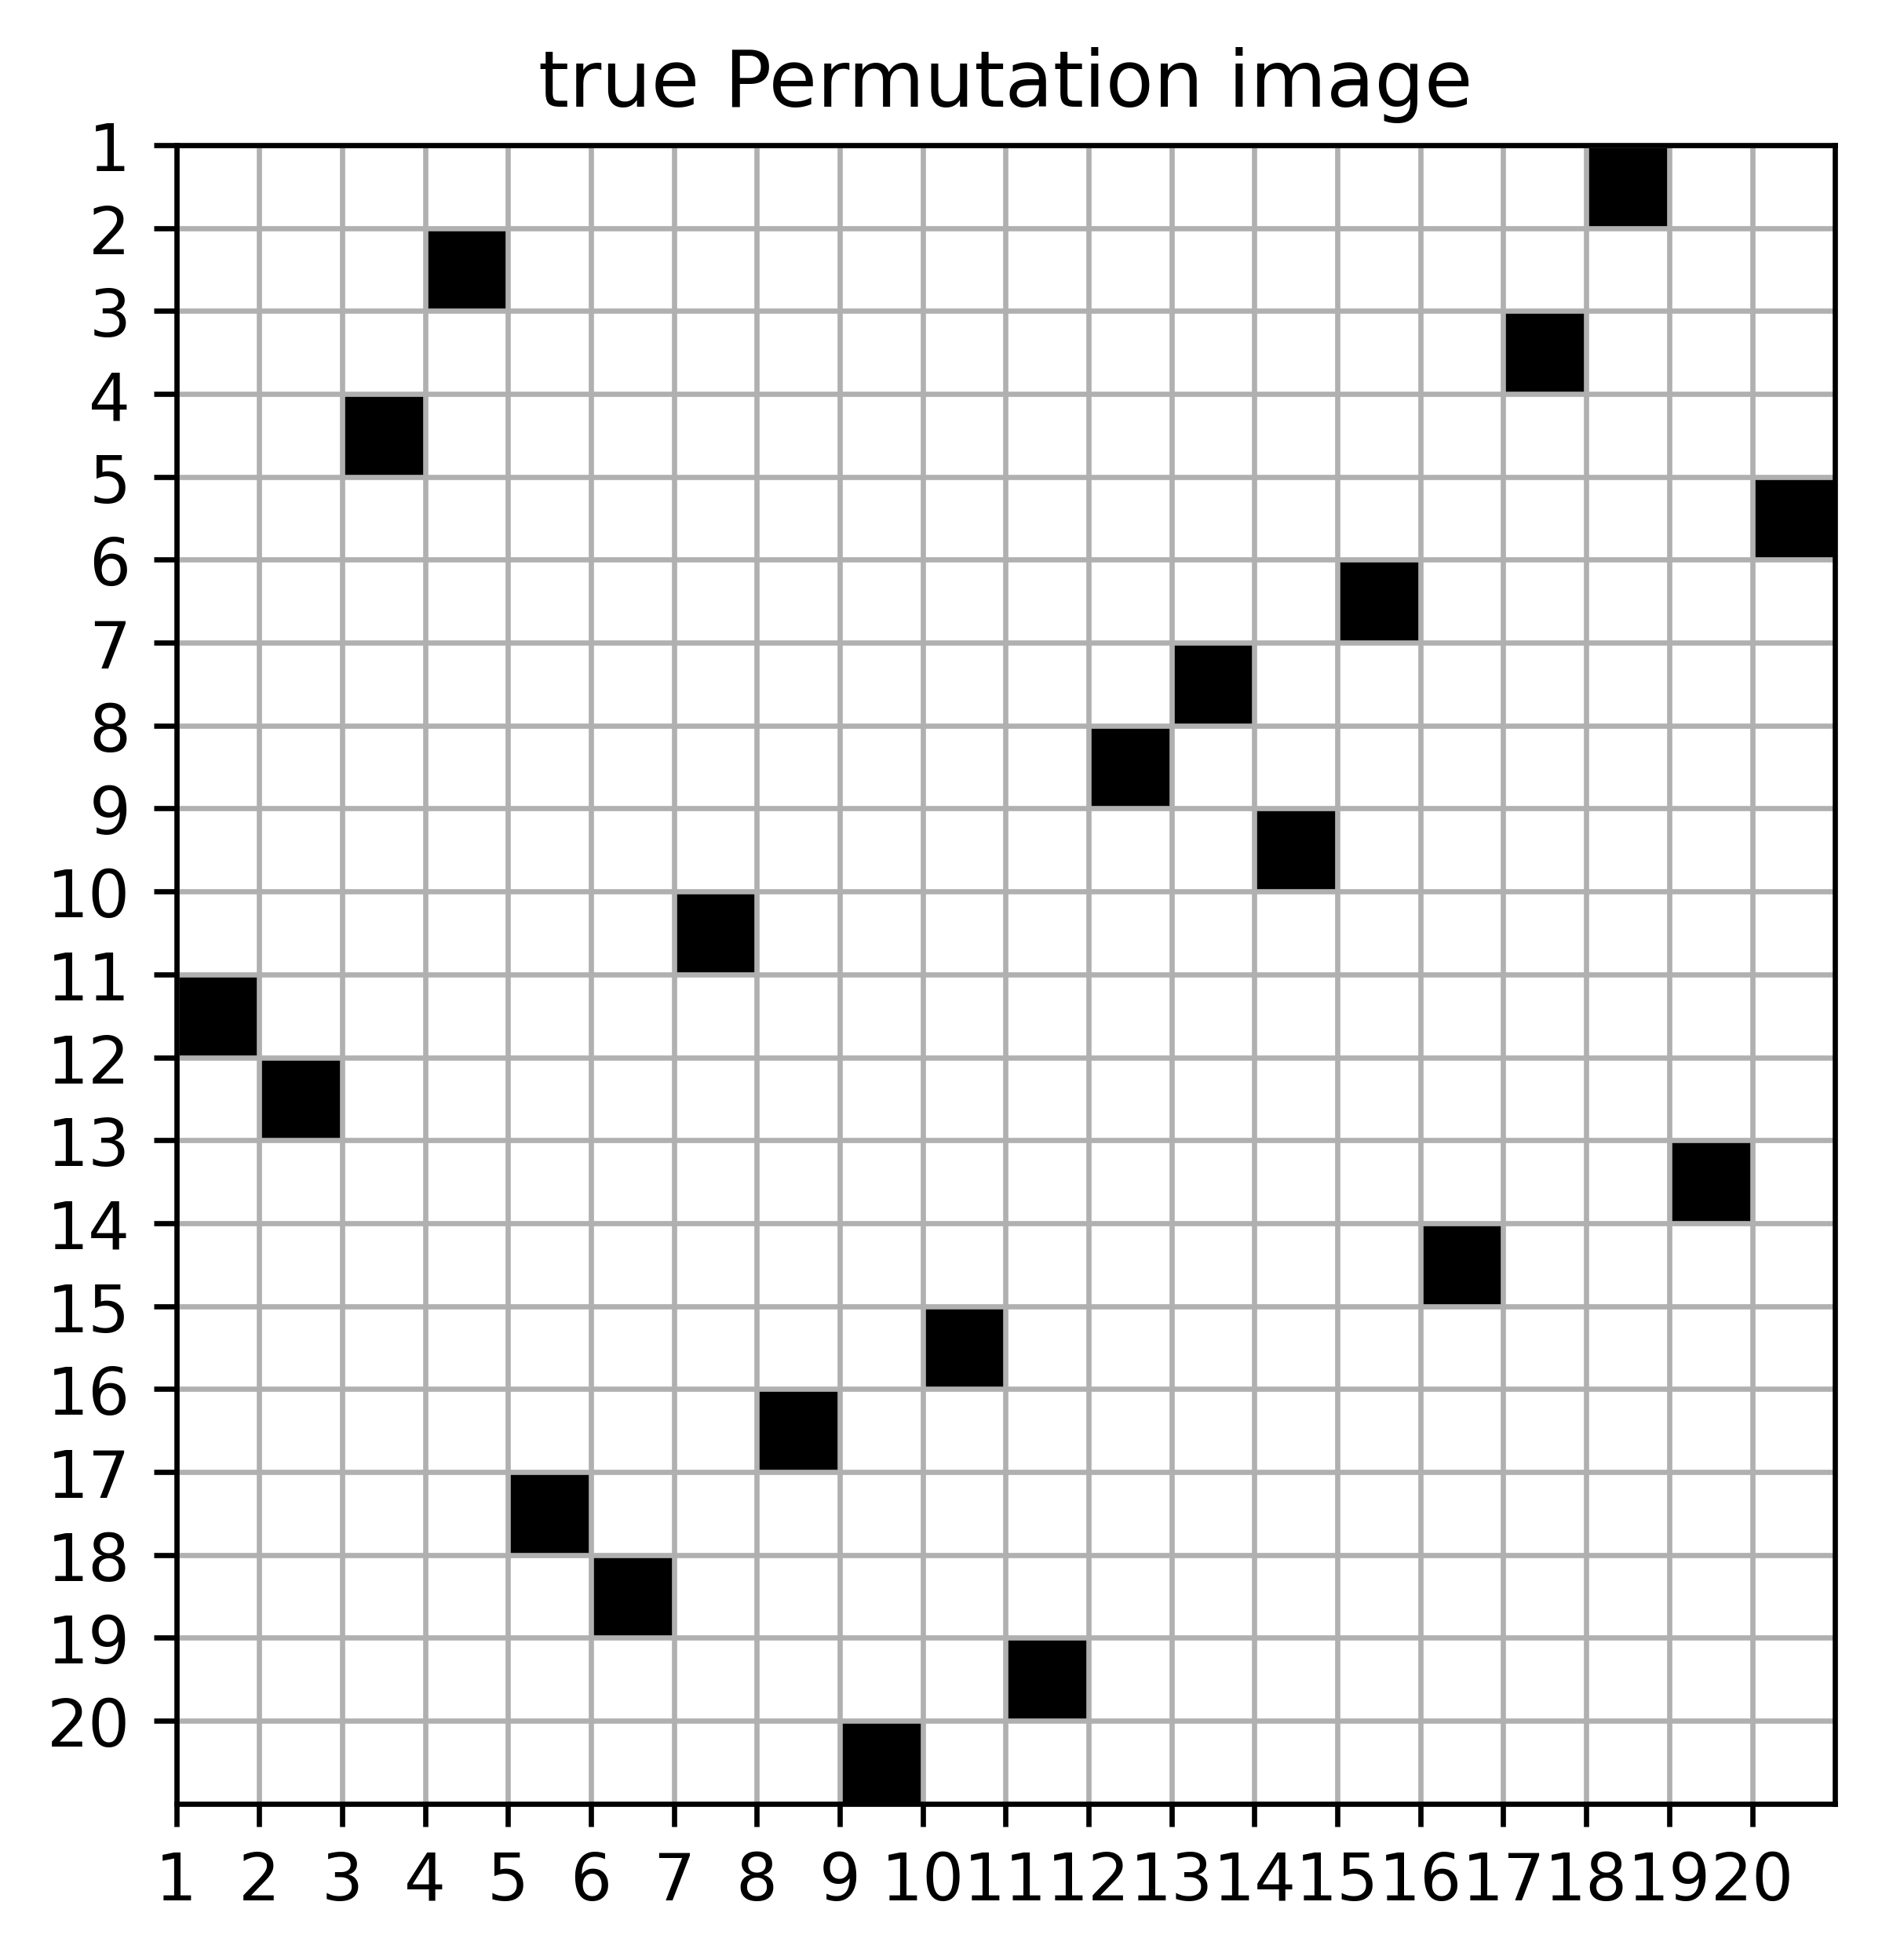

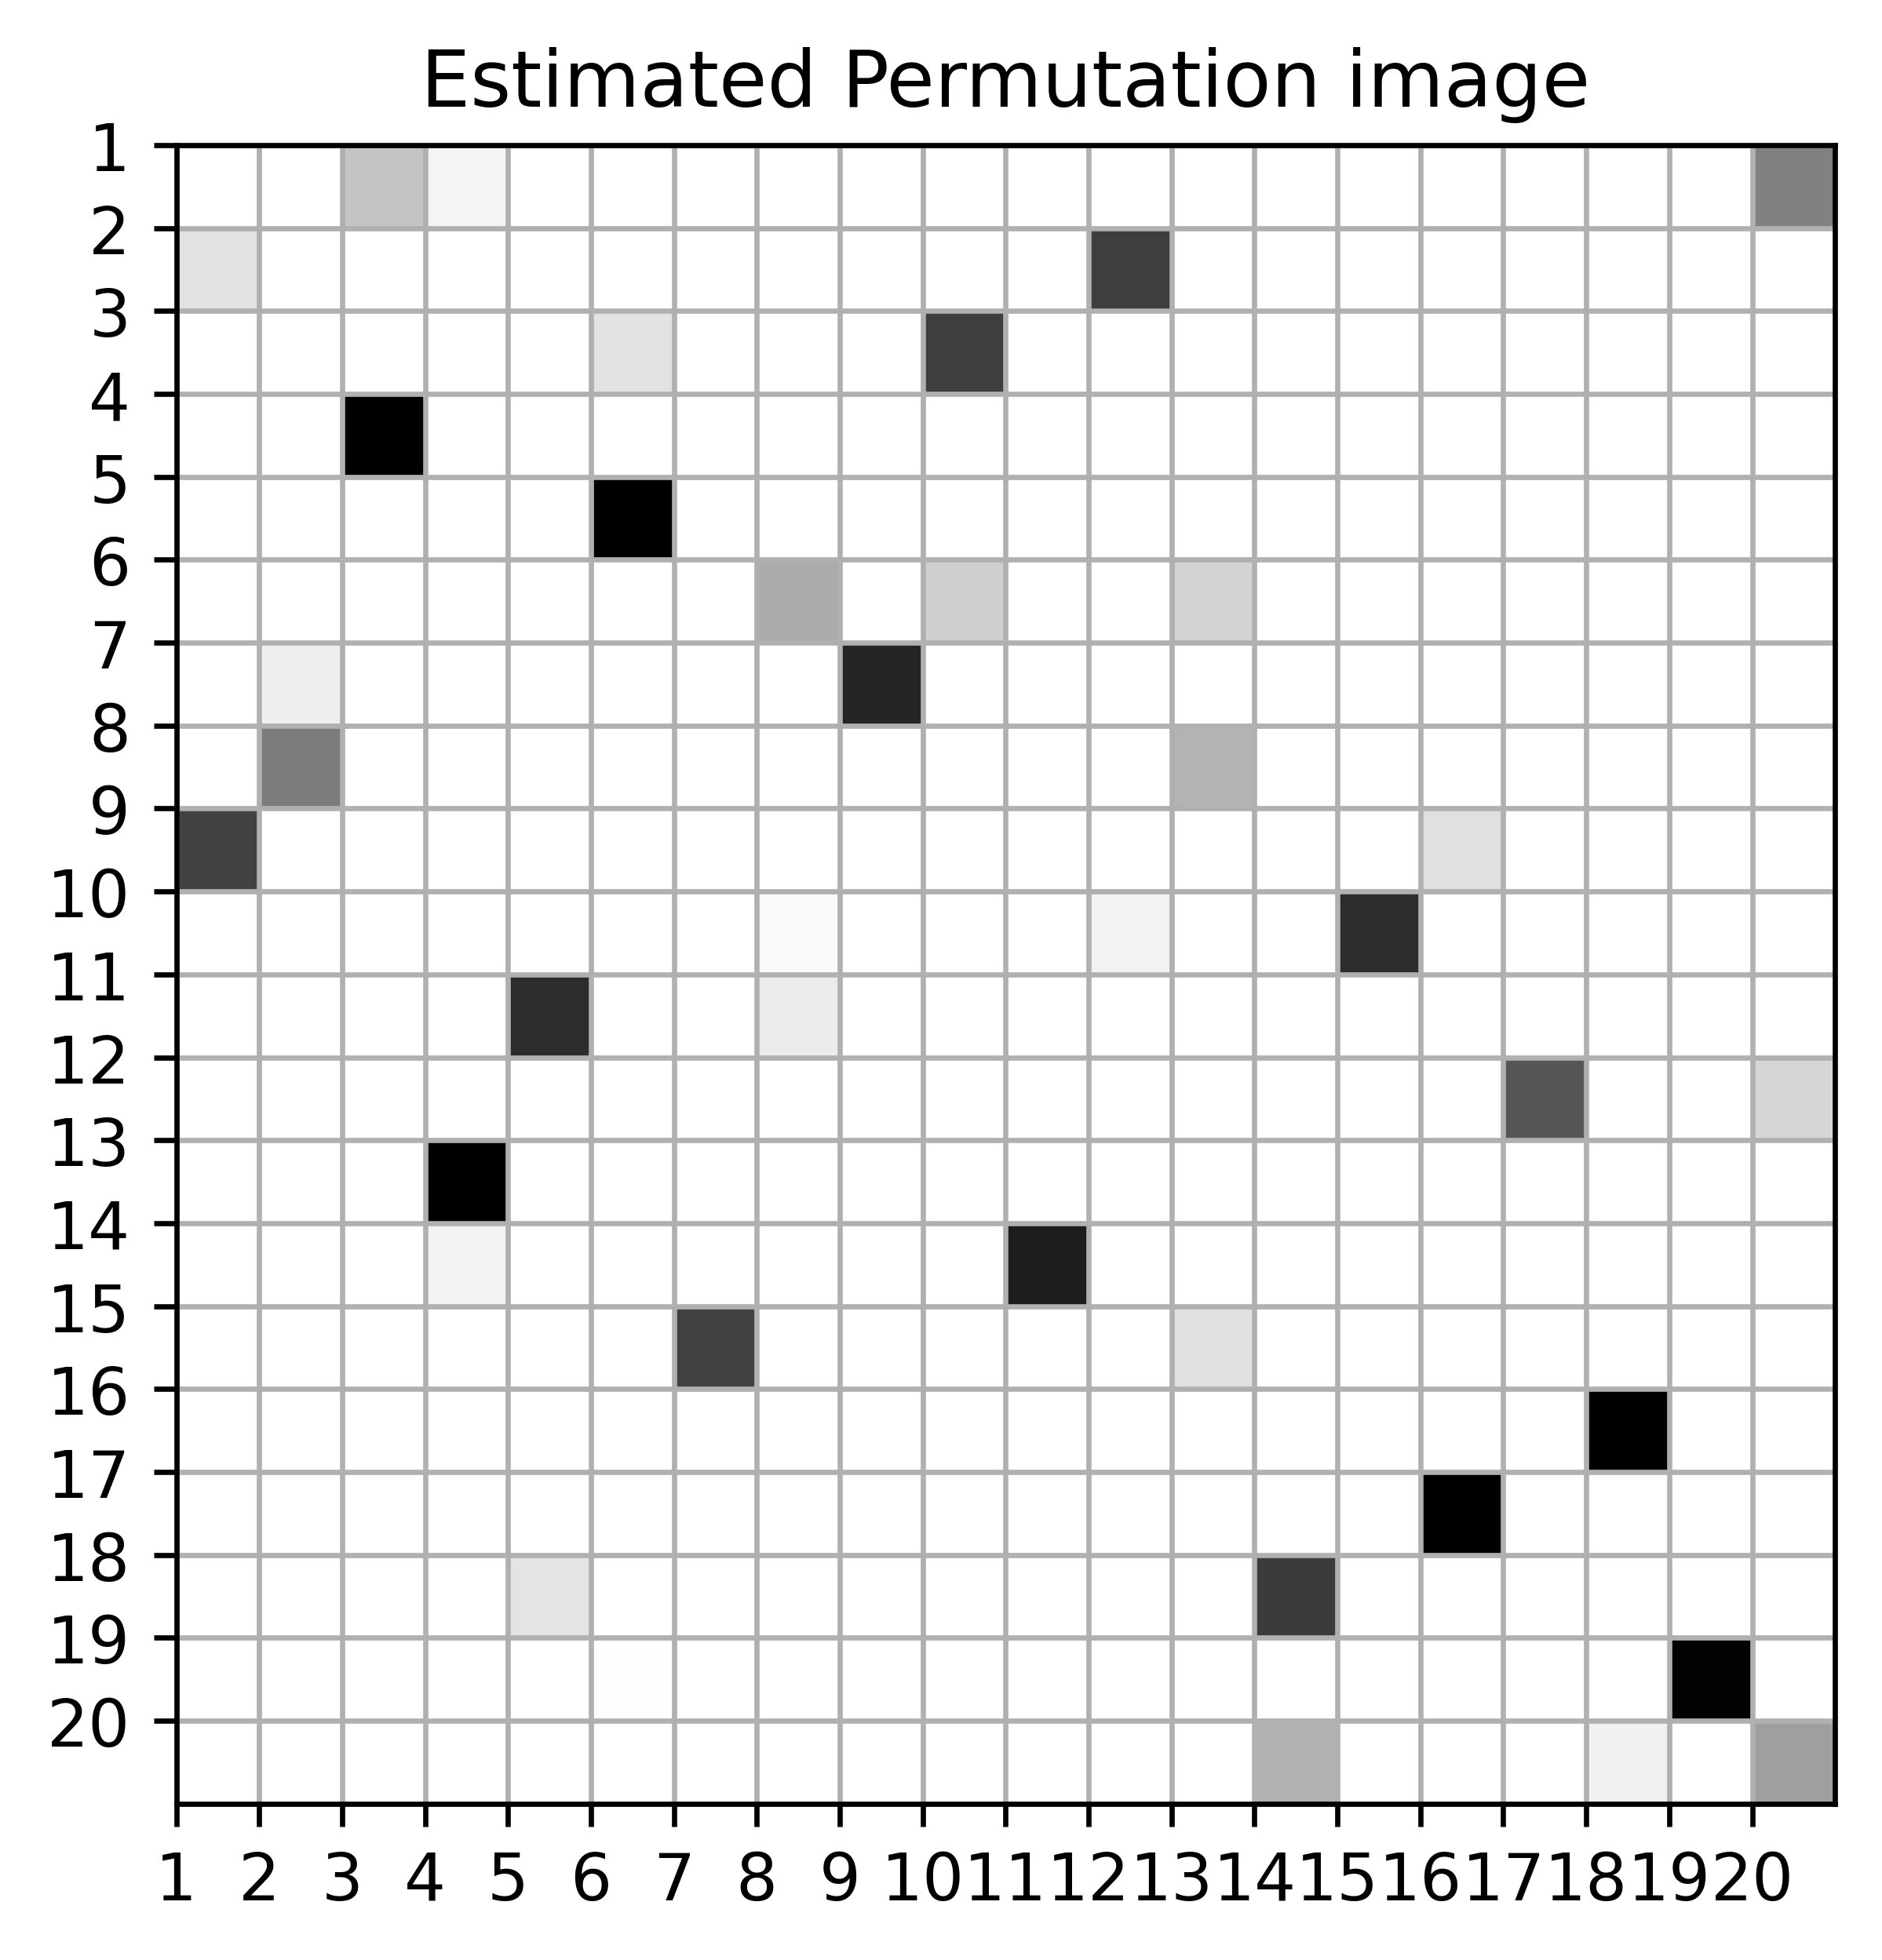

In [ ]:
# load and show the True permutation
fig, ax = plt.subplots(figsize=(10,10),dpi=600)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
    ax.spines[axis].set_color("black")
    ax.spines[axis].set_zorder(0)
a = plt.imread("true_PI.png")
K_ = [-0.5+i for i in range(20)]
idx = [i+1 for i in range(20)]
plt.subplot(1,2,1)
plt.imshow(a)
plt.title("true Permutation image")
plt.xticks(K_, idx)
plt.yticks(K_, idx)
plt.grid(True)

fig, ax = plt.subplots(figsize=(10,10),dpi=600)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
    ax.spines[axis].set_color("black")
    ax.spines[axis].set_zorder(0)
# load and show the Estimate permutation
a = plt.imread("esti_PI.png")
plt.subplot(1,2,2)
plt.imshow(a)
plt.title("Estimated Permutation image")
plt.xticks(K_, idx)
plt.yticks(K_, idx)
plt.grid(True)

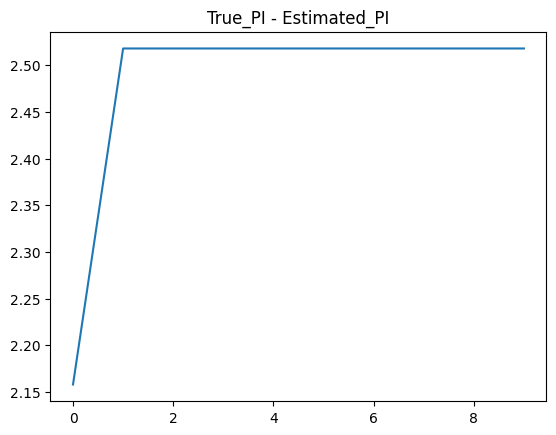

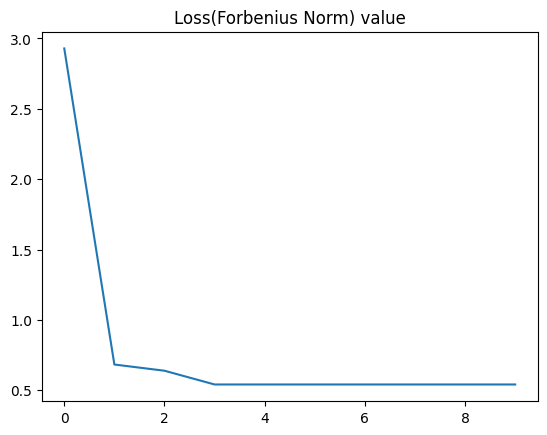

[13.044373219397624, 13.14876619130569, 13.601215708574092, 13.601215708574092, 13.601215708574092, 13.601215708574092, 13.601215708574092, 13.601215708574092, 13.601215708574092]


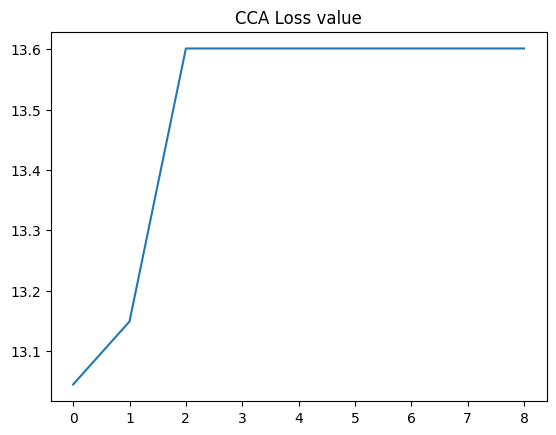

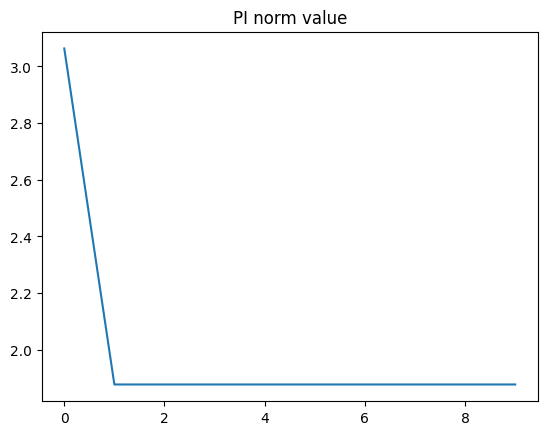

In [ ]:
import math
plt.plot([math.log2(i) for i in fro_norm_list])
plt.title("True_PI - Estimated_PI")
plt.show()

plt.plot([math.log2(i) for i in fro_loss_list])
plt.title("Loss(Forbenius Norm) value")
plt.show()

print(CCA_loss_list)
# plt.plot([math.log2(i) for i in CCA_loss_list])
plt.plot([i for i in CCA_loss_list])
plt.title("CCA Loss value")
plt.show()

plt.plot([math.log2(i) for i in PI_norm_list])
plt.title("PI norm value")
plt.show()

In [ ]:
################################
#  verify different parameters #
################################

# the list of hyperparameters of lambda and entropy_threshold
lambda_range = np.logspace(-4, 1, 6)
entropy_thre_range = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0]

esti_PI_list = []
for lambda_i in lambda_range:
    for entropy_i in entropy_thre_range:
        for i in range(train_epoch): 
            ## update Permutation with datasets (X, Y), and fixed (U, V, S)
            t_PI = time.time()
            if i > 0:
                esti_PI = optimize_PI(esti_PI, X, Y, U, V, S, n, \
                                      lambda_1=lambda_i, \
                                      lambda_2=lambda_i, \
                                      entropy_threshold=entropy_i).reshape(n, n)
            else:
                # initialize the PI at totally random
                for j in range(int(n)):
                    esti_PI[j] = np.random.dirichlet(np.ones(n),size=1)[0]
            t_PI = time.time() - t_PI
            print("# iter=", i, ", Permutation part time-cost = ", t_PI)
            ## update the projections with datasets (X, Y), and fixed permutation PI
            # train with the input as: (X, PI*Y)
            t_CCA = time.time()
            U, V, S = MAXVAR_MCCA(X, Y, esti_PI)
            t_CCA = time.time() - t_CCA
            print("# iter=", i, ", CCA part time-cost = ", t_CCA)
        # save each estimated PI
        esti_PI_list.append(esti_PI)
        

In [ ]:
print(np.array(esti_PI_list).shape)
# calculate the top-K accuracy
K_list = [i+1 for i in range(10)]
best_lambda = []
best_entropy = []

# calculate the top-K accuracy based on different K values
for k in K_list:
    acc = np.zeros(36)
    for PI_index in range(len(esti_PI_list)):
        for i in range(len(true_PI)):
            pred = np.argsort(esti_PI_list[PI_index][i])[-k:]
            label = np.argmax(true_PI[i])
            if np.any(pred == label):
                acc[PI_index] += 1
        acc[PI_index] = acc[PI_index] / n
    acc_index = np.argmax(acc[PI_index])
    # record the best hyperparameters for top-k
    best_lambda.append(lambda_range[int(acc_index/6)])
    best_entropy.append(entropy_thre_range[int(acc_index%6)])
print(best_lambda)
print(best_entropy)

In [ ]:
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
xline = np.array(K_list)
yline = np.array(best_lambda)
zline = np.array(best_entropy)
ax.scatter3D(xline, yline, zline, 'gray')
ax.set_xlabel('K')
ax.set_ylabel('lambda')
ax.set_zlabel('entropy');

In [ ]:
# record different loss values
optim_loss_list = [[] for i in range(n)]
fro_loss_list = [[] for i in range(n)]
CCA_loss_list = [[] for i in range(n)]
PI_loss_list = [[] for i in range(n)]

# record the history estimated PI
esti_PI_list = []

for j in range(n):
    for i in range(train_epoch): 
        ## update Permutation with datasets (X, Y), and fixed (U, V, S)
        t_PI = time.time()
        if i > 0:
            esti_PI = optimize_PI(esti_PI, X, Y, U, V, S, 20).reshape(20, 20)
        else:
            esti_PI = copy.deepcopy(true_PI)
            # initialize the PI at totally random
            for row in range(int(n)):
                esti_PI[row] = np.random.dirichlet(np.ones(20),size=1)[0]
        t_PI = time.time() - t_PI
        ## update the projections with datasets (X, Y), and fixed permutation PI
        # train with the input as: (X, PI*Y)
        t_CCA = time.time()
        U, V, S = MAXVAR_MCCA(X, Y, esti_PI)
        t_CCA = time.time() - t_CCA
        # compute the main optimization error
        YTV = np.dot(Y.T, V)
        YTVVTY = np.dot(YTV, YTV.T)
        YTVS = np.dot(np.dot(Y.T, V), S)
        optim_loss_list[j].append(np.linalg.norm(np.dot(YTVVTY, esti_PI) - YTVS, "fro"))
        # compute || true_PI - esti_PI ||
        fro_norm = np.linalg.norm(true_PI - esti_PI, "fro")
        fro_loss_list[j].append(fro_norm)
        # calculate || PI.T*PI - I || loss
        PI_norm = np.linalg.norm((np.dot(esti_PI, esti_PI.T) - np.identity(20)), "fro") \
                  + np.linalg.norm((np.dot(esti_PI.T, esti_PI) - np.identity(20)), "fro")
        PI_loss_list[j].append(PI_norm)
        # calculate the CCA loss: UX - VY*PI
        if i == 0:
            init_CCA_loss = np.linalg.norm(np.dot(U.T, X) - np.dot(V.T, np.dot(Y, true_PI)), "fro")
        else:
            CCA_loss_curr = np.linalg.norm(np.dot(U.T, X) - np.dot(V.T, np.dot(Y, true_PI)), "fro")
            CCA_loss = abs(init_CCA_loss - CCA_loss_curr)
        if i > 0:
            CCA_loss_list[j].append(CCA_loss)
        print("# Running time-", j, ", iter = ", i, " ...")
            
    esti_PI_list.append(esti_PI)
    

# Running time- 0 , iter =  0  ...
# Running time- 0 , iter =  1  ...
# Running time- 0 , iter =  2  ...
# Running time- 0 , iter =  3  ...
# Running time- 0 , iter =  4  ...
# Running time- 0 , iter =  5  ...
# Running time- 0 , iter =  6  ...
# Running time- 0 , iter =  7  ...
# Running time- 0 , iter =  8  ...
# Running time- 0 , iter =  9  ...
# Running time- 1 , iter =  0  ...
# Running time- 1 , iter =  1  ...
# Running time- 1 , iter =  2  ...
# Running time- 1 , iter =  3  ...
# Running time- 1 , iter =  4  ...
# Running time- 1 , iter =  5  ...
# Running time- 1 , iter =  6  ...
# Running time- 1 , iter =  7  ...
# Running time- 1 , iter =  8  ...
# Running time- 1 , iter =  9  ...
# Running time- 2 , iter =  0  ...
# Running time- 2 , iter =  1  ...
# Running time- 2 , iter =  2  ...
# Running time- 2 , iter =  3  ...
# Running time- 2 , iter =  4  ...
# Running time- 2 , iter =  5  ...
# Running time- 2 , iter =  6  ...
# Running time- 2 , iter =  7  ...
# Running time- 2 , 

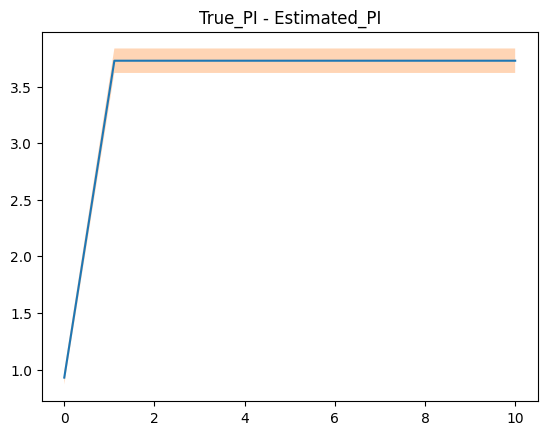

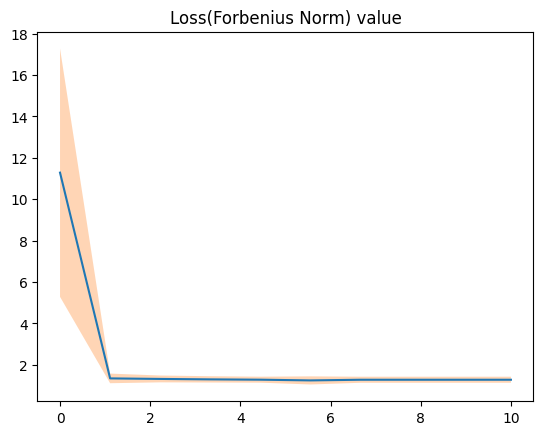

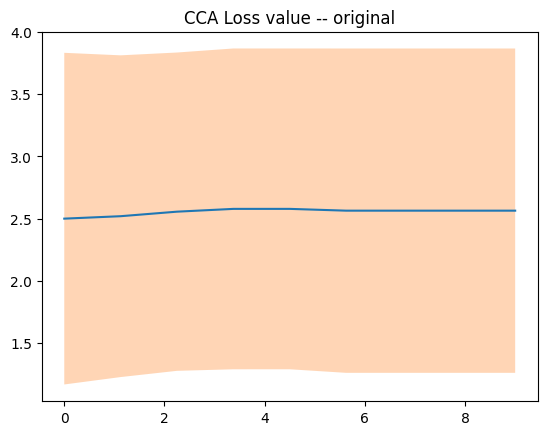

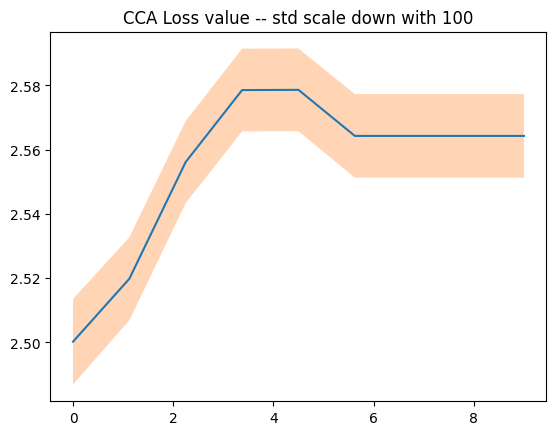

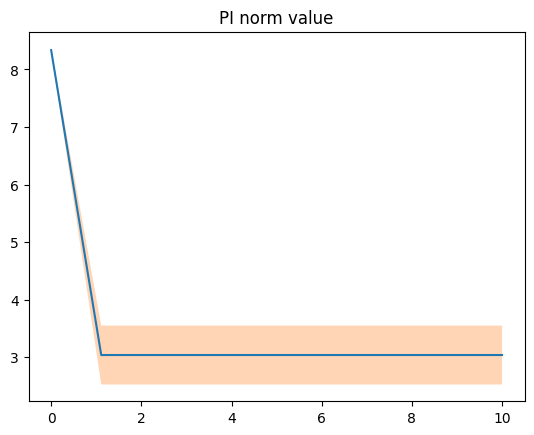

In [ ]:
# calclulate the mean and std
optim_loss_mean = np.mean(np.array(optim_loss_list), axis=0)
fro_loss_mean = np.mean(np.array(fro_loss_list), axis=0)
CCA_loss_mean = np.mean(np.array(CCA_loss_list), axis=0)
PI_loss_mean = np.mean(np.array(PI_loss_list), axis=0)

optim_loss_std = np.std(np.array(optim_loss_list), axis=0)
fro_loss_std = np.std(np.array(fro_loss_list), axis=0)
CCA_loss_std = np.std(np.array(CCA_loss_list), axis=0)
PI_loss_std = np.std(np.array(PI_loss_list), axis=0)

# plot each error curves
import math
# plt.plot([math.log2(i) for i in fro_norm_list])
plt.plot(np.linspace(0, n, n), fro_loss_mean)
plt.fill_between(np.linspace(0, n, n), \
                 fro_loss_mean - fro_loss_std, \
                 fro_loss_mean + fro_loss_std, alpha=0.4, facecolor='#FF9848')
plt.title("True_PI - Estimated_PI")
plt.show()

# plt.plot([math.log2(i) for i in fro_loss_list])
plt.plot(np.linspace(0, n, n), optim_loss_mean)
plt.fill_between(np.linspace(0, n, n), \
                 optim_loss_mean - optim_loss_std, \
                 optim_loss_mean + optim_loss_std, alpha=0.4, facecolor='#FF9848')
plt.title("Loss(Forbenius Norm) value")
plt.show()

# plt.plot([math.log2(i) for i in CCA_loss_list])
plt.plot(np.linspace(0, n-1, n-1), CCA_loss_mean)
plt.fill_between(np.linspace(0, n-1, n-1), \
                 CCA_loss_mean - CCA_loss_std, \
                 CCA_loss_mean + CCA_loss_std, alpha=0.4, facecolor='#FF9848')
plt.title("CCA Loss value -- original")
plt.show()


# plt.plot([math.log2(i) for i in CCA_loss_list])
plt.plot(np.linspace(0, n-1, n-1), CCA_loss_mean)
plt.fill_between(np.linspace(0, n-1, n-1), \
                 CCA_loss_mean - CCA_loss_std/100, \
                 CCA_loss_mean + CCA_loss_std/100, alpha=0.4, facecolor='#FF9848')
plt.title("CCA Loss value -- std scale down with 100")
plt.show()

# plt.plot([math.log2(i) for i in PI_norm_list])
plt.plot(np.linspace(0, n, n), PI_loss_mean)
plt.fill_between(np.linspace(0, n, n), \
                 PI_loss_mean - PI_loss_std, \
                 PI_loss_mean + PI_loss_std, alpha=0.4, facecolor='#FF9848')
plt.title("PI norm value")
plt.show()

[[0.3  0.3  0.25 0.2  0.2  0.3  0.15 0.2  0.25 0.2 ]
 [0.4  0.6  0.4  0.5  0.55 0.45 0.45 0.35 0.45 0.3 ]
 [0.4  0.6  0.4  0.65 0.55 0.5  0.5  0.4  0.5  0.35]
 [0.5  0.6  0.4  0.7  0.55 0.6  0.5  0.55 0.55 0.4 ]
 [0.55 0.65 0.4  0.7  0.55 0.65 0.6  0.55 0.6  0.45]]
# K =  1 , mean =  0.23500000000000001  and std =  0.050249378105604446
# K =  2 , mean =  0.445  and std =  0.085
# K =  3 , mean =  0.485  and std =  0.09233092656309695
# K =  4 , mean =  0.535  and std =  0.08674675786448735
# K =  5 , mean =  0.5700000000000001  and std =  0.08717797887081345


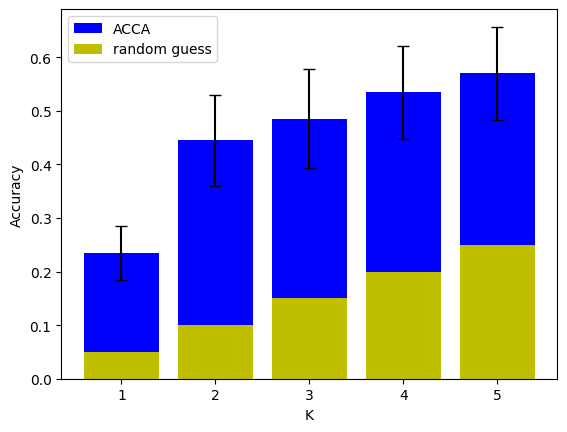

In [ ]:
# calculate the top-K accuracy
K_list = [i+1 for i in range(5)]
acc_list = [[] for i in range(len(K_list))]
for k in range(len(K_list)):
    for j in range(n):
        acc = 0.0
        for i in range(len(true_PI)):
            pred = np.argsort(esti_PI_list[j][i])[-K_list[k]:]
            label = np.argmax(true_PI[i])
            if np.any(pred == label):
                acc += 1
        acc = acc / 20
        acc_list[k].append(acc)
        
print(np.array(acc_list))

mean_list = []
std_list = []
for i in range(len(acc_list)):
    acc_i = acc_list[i]
    mean_i = np.mean(acc_i)
    mean_list.append(mean_i)
    std_i = np.std(acc_i)
    std_list.append(std_i)
    print("# K = ", i+1, ", mean = ", mean_i, " and std = ", std_i)

import matplotlib.pyplot as plt
idx = [i+1 for i in range(5)]
random_guess = [k/20 for k in K_list]

fig, ax = plt.subplots()
plt.bar(idx, mean_list, yerr=std_list, color='b', capsize=4)
plt.bar(idx, random_guess, color='y')
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.legend(['ACCA', 'random guess'])
plt.show()

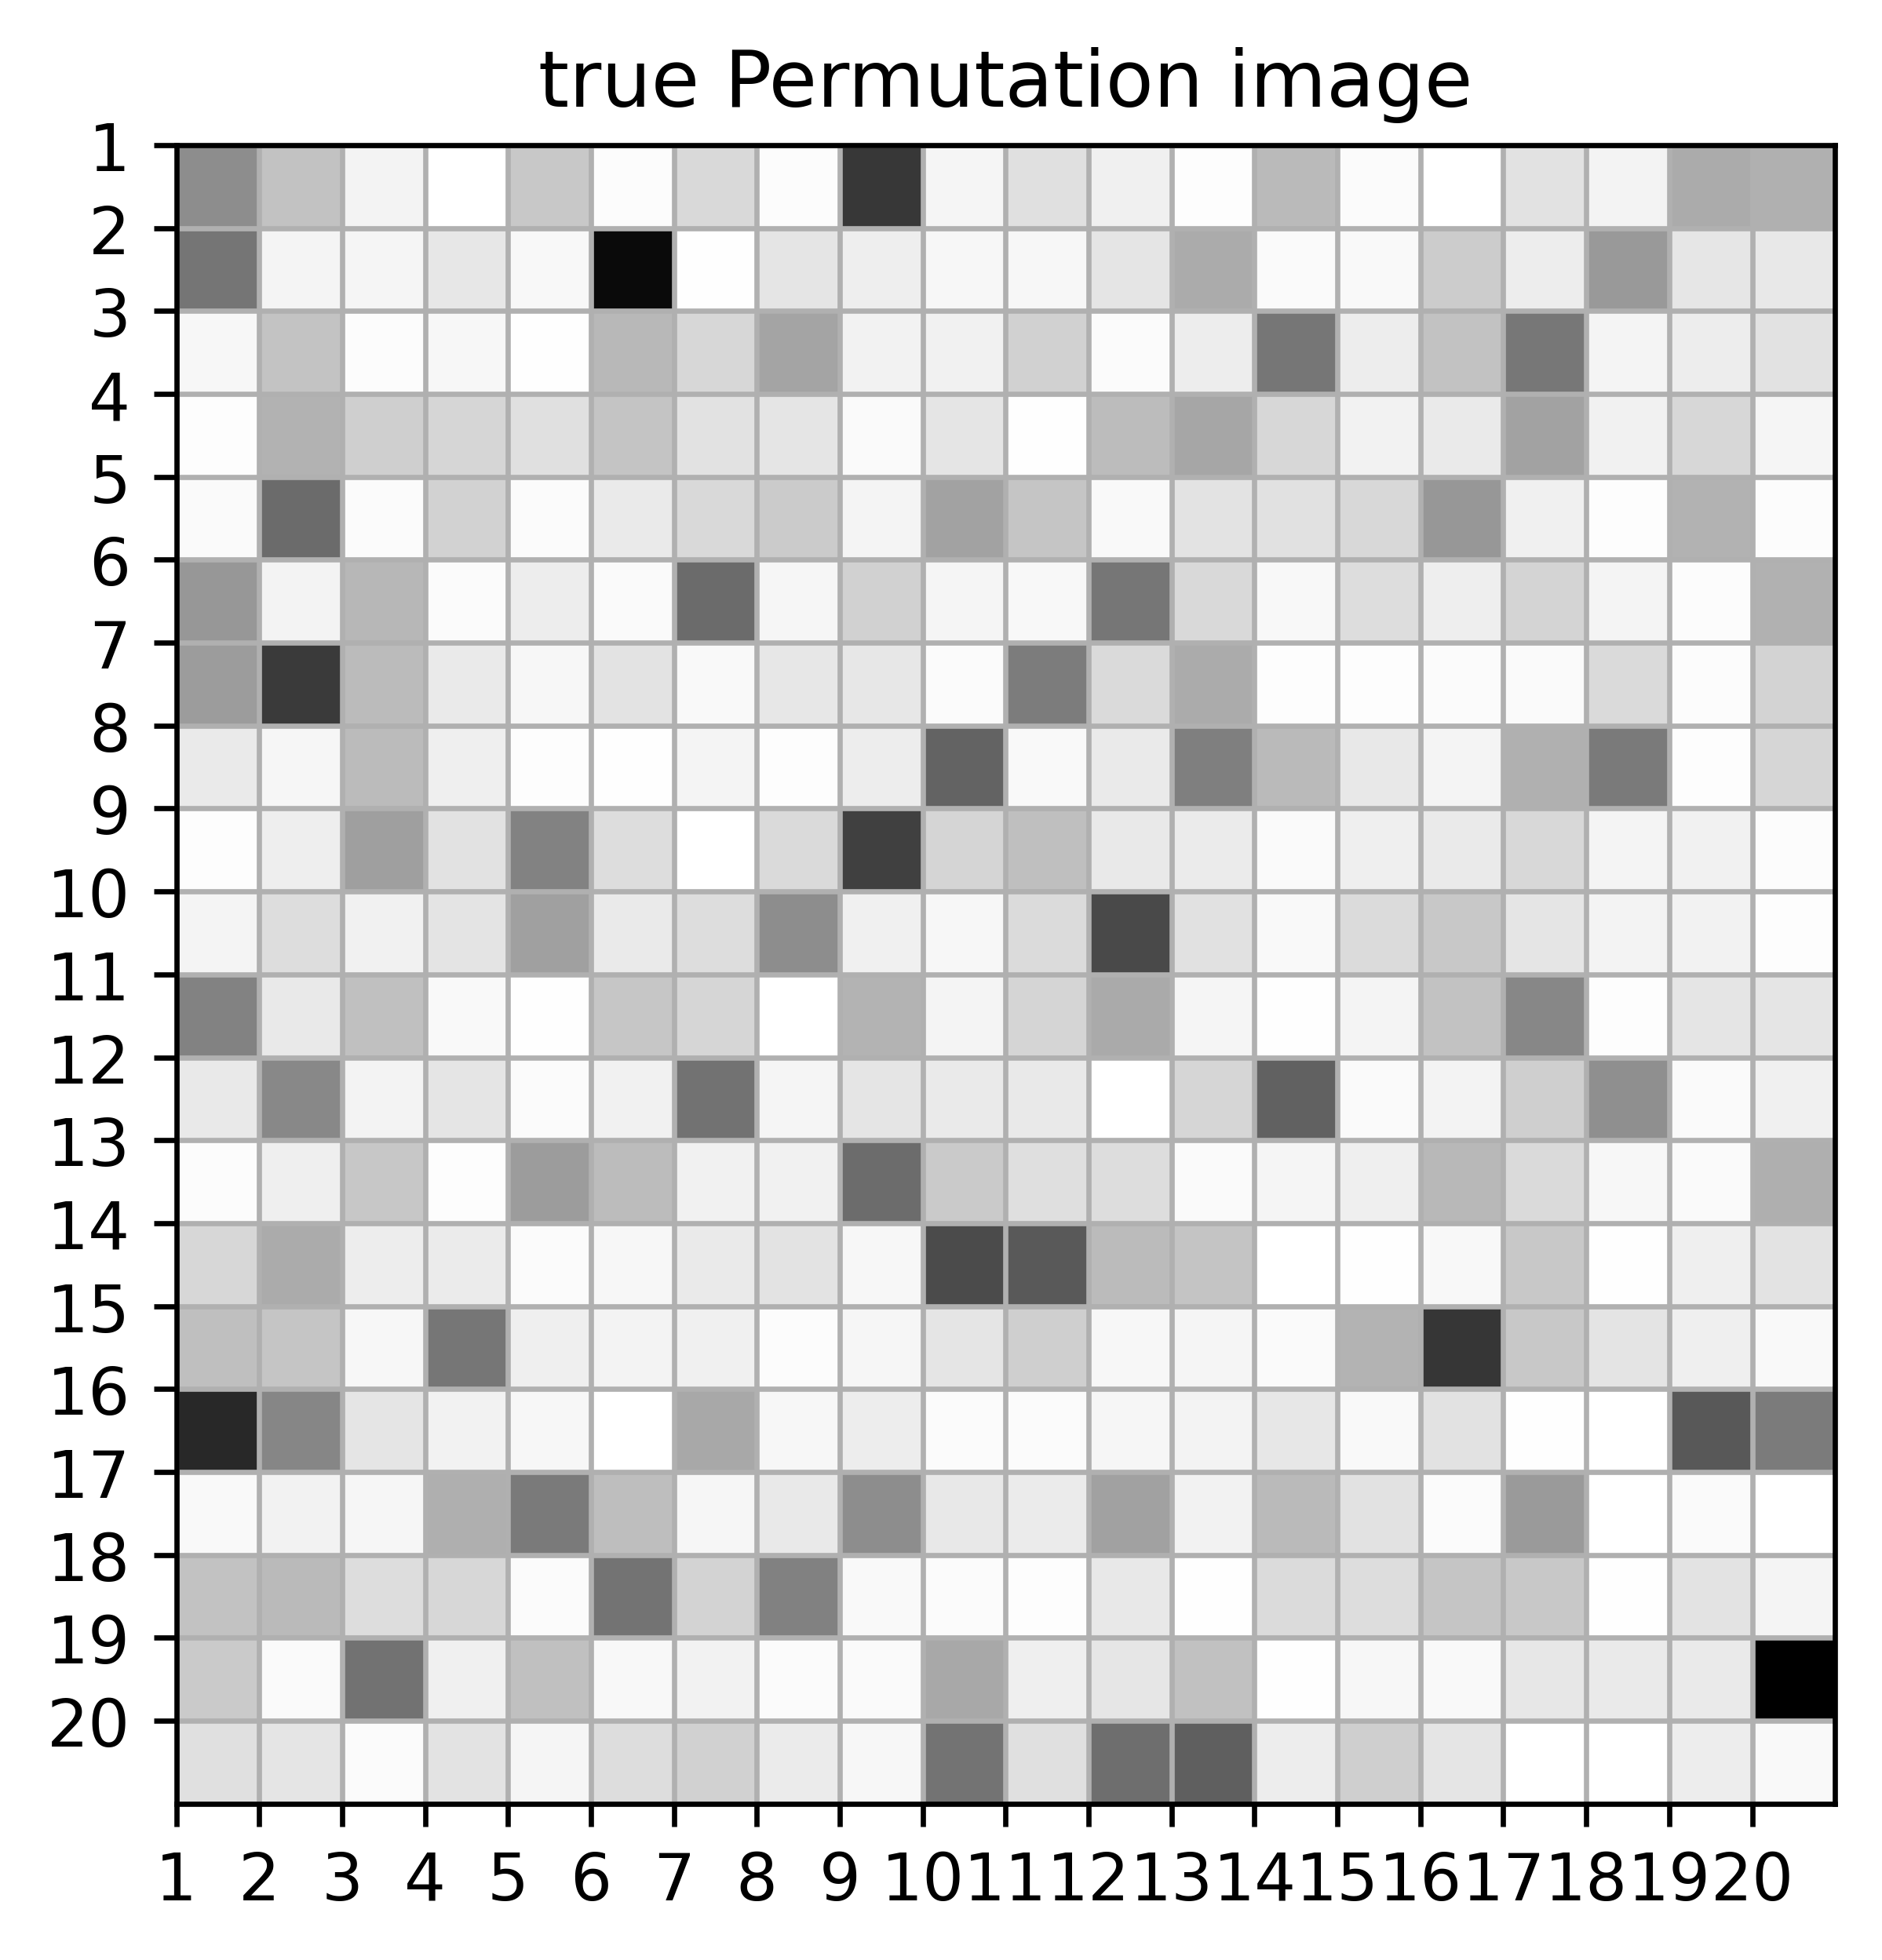

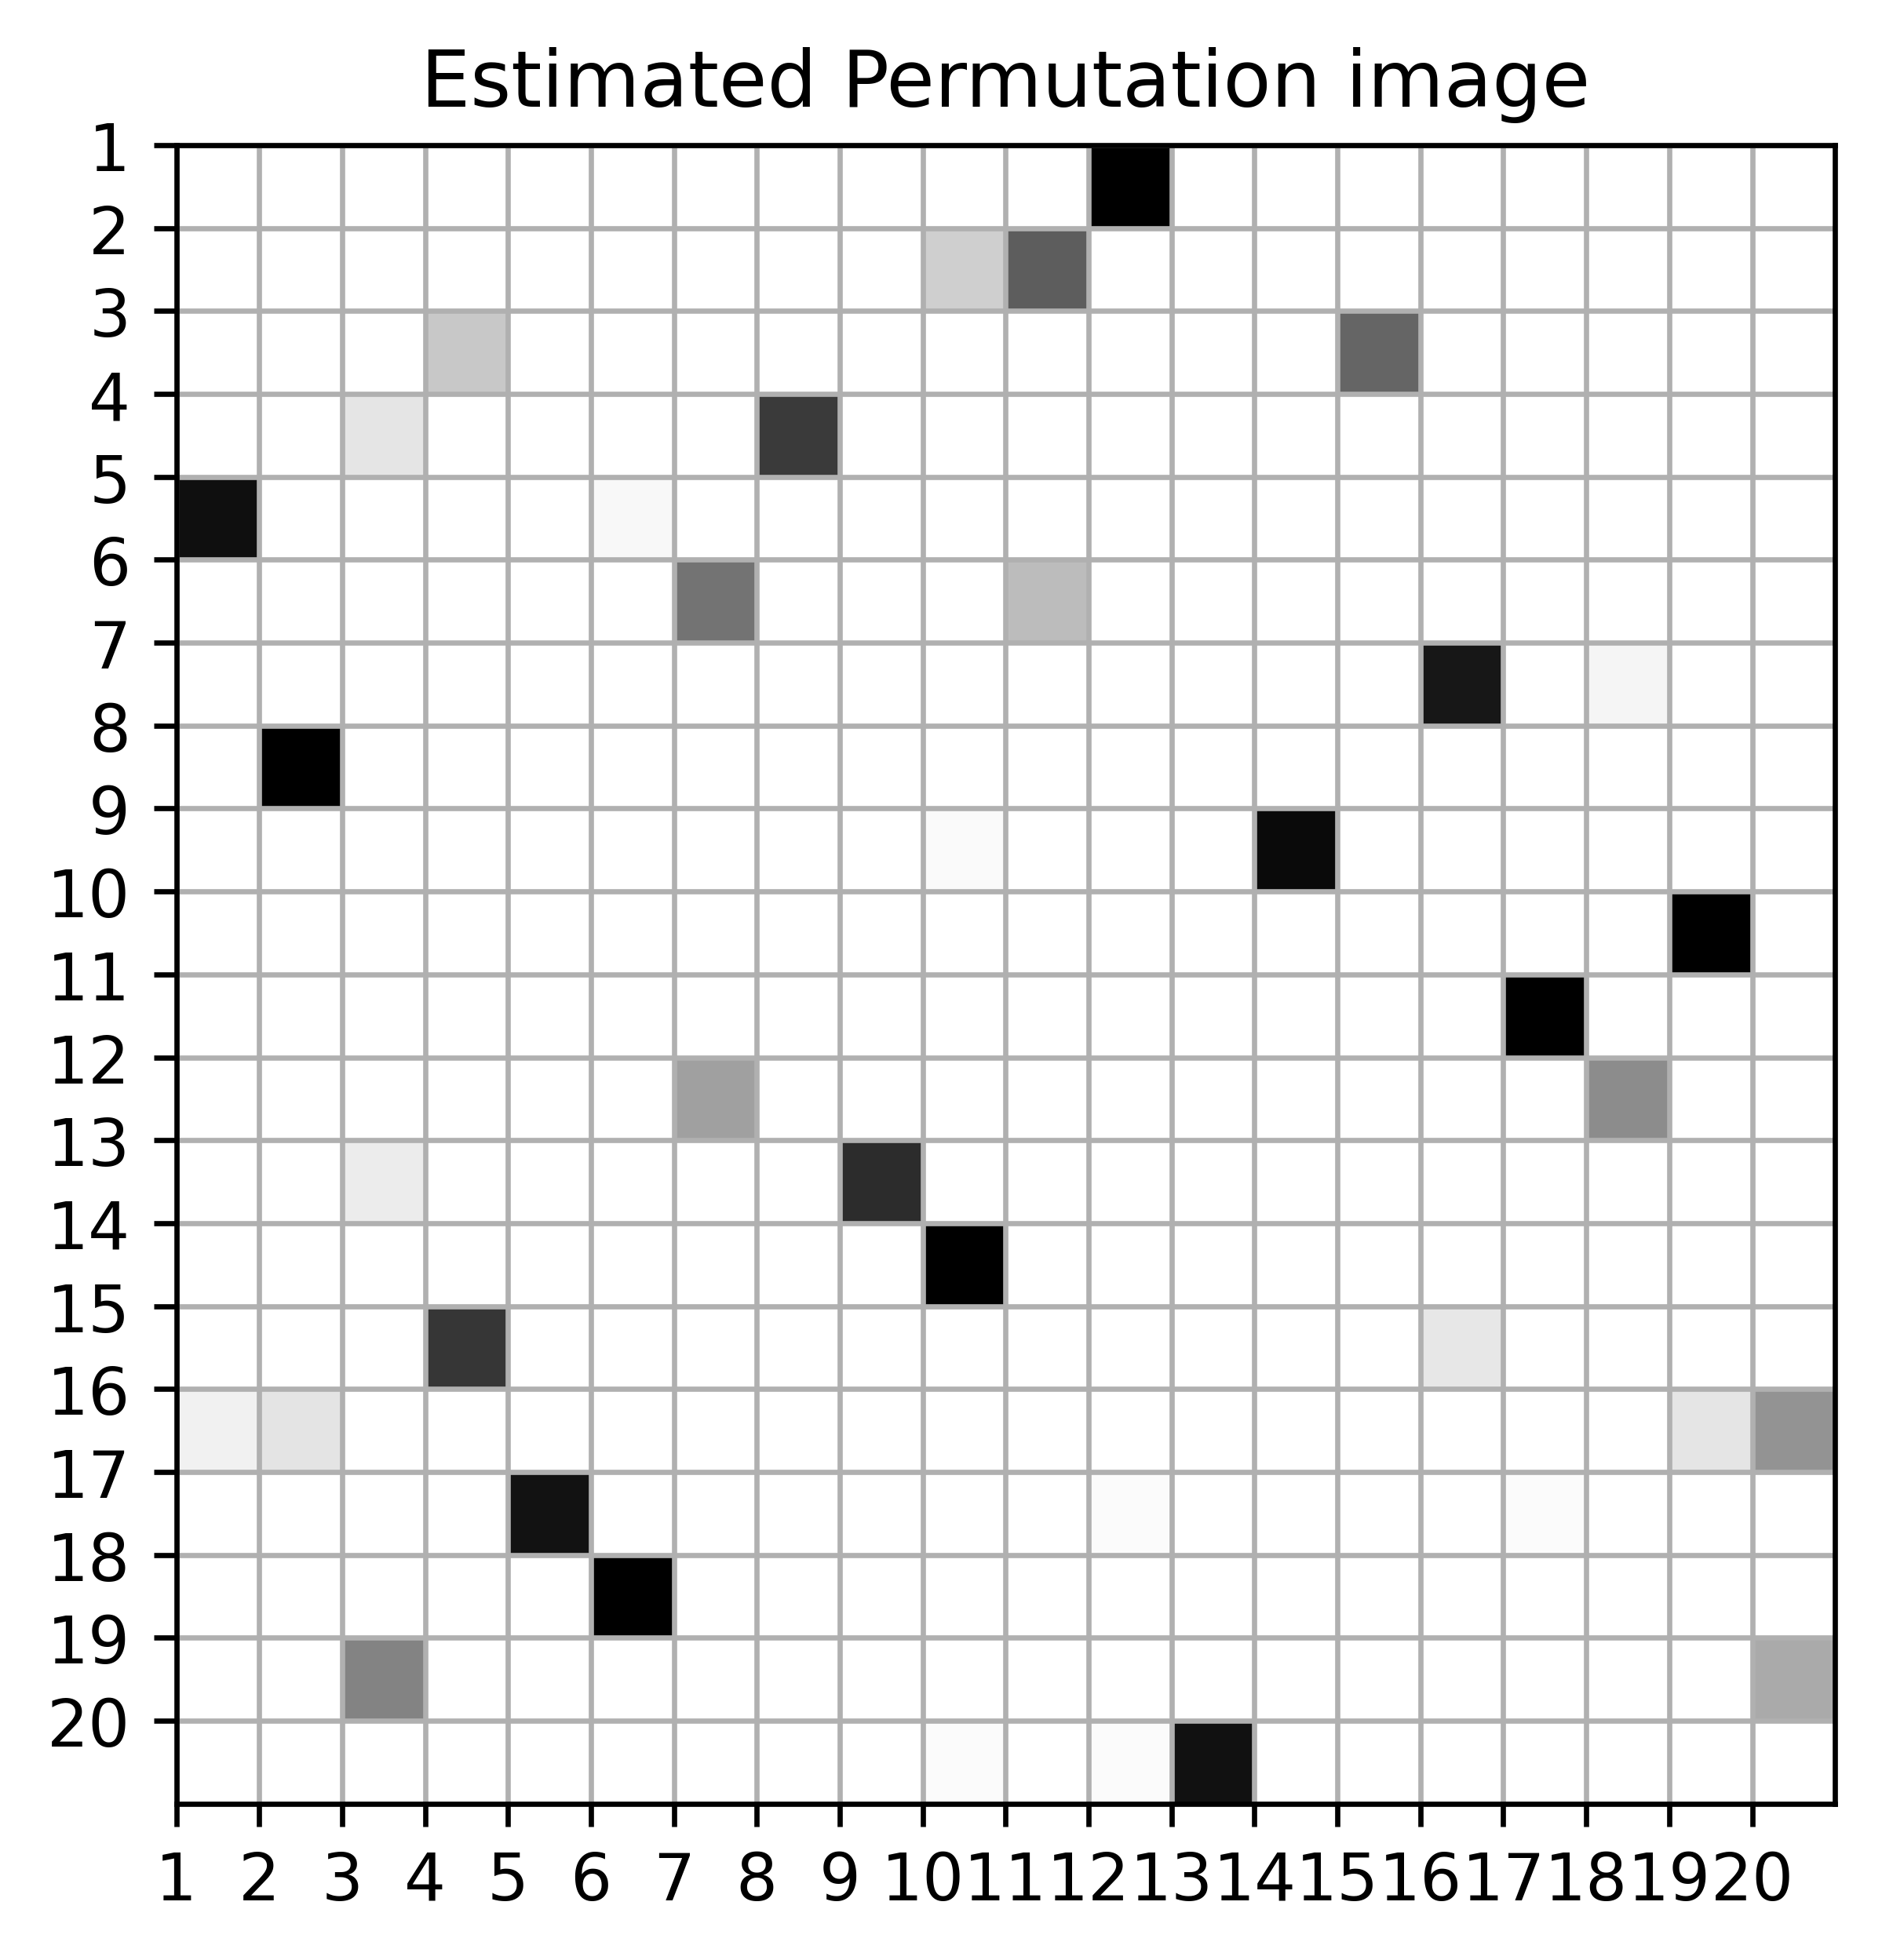

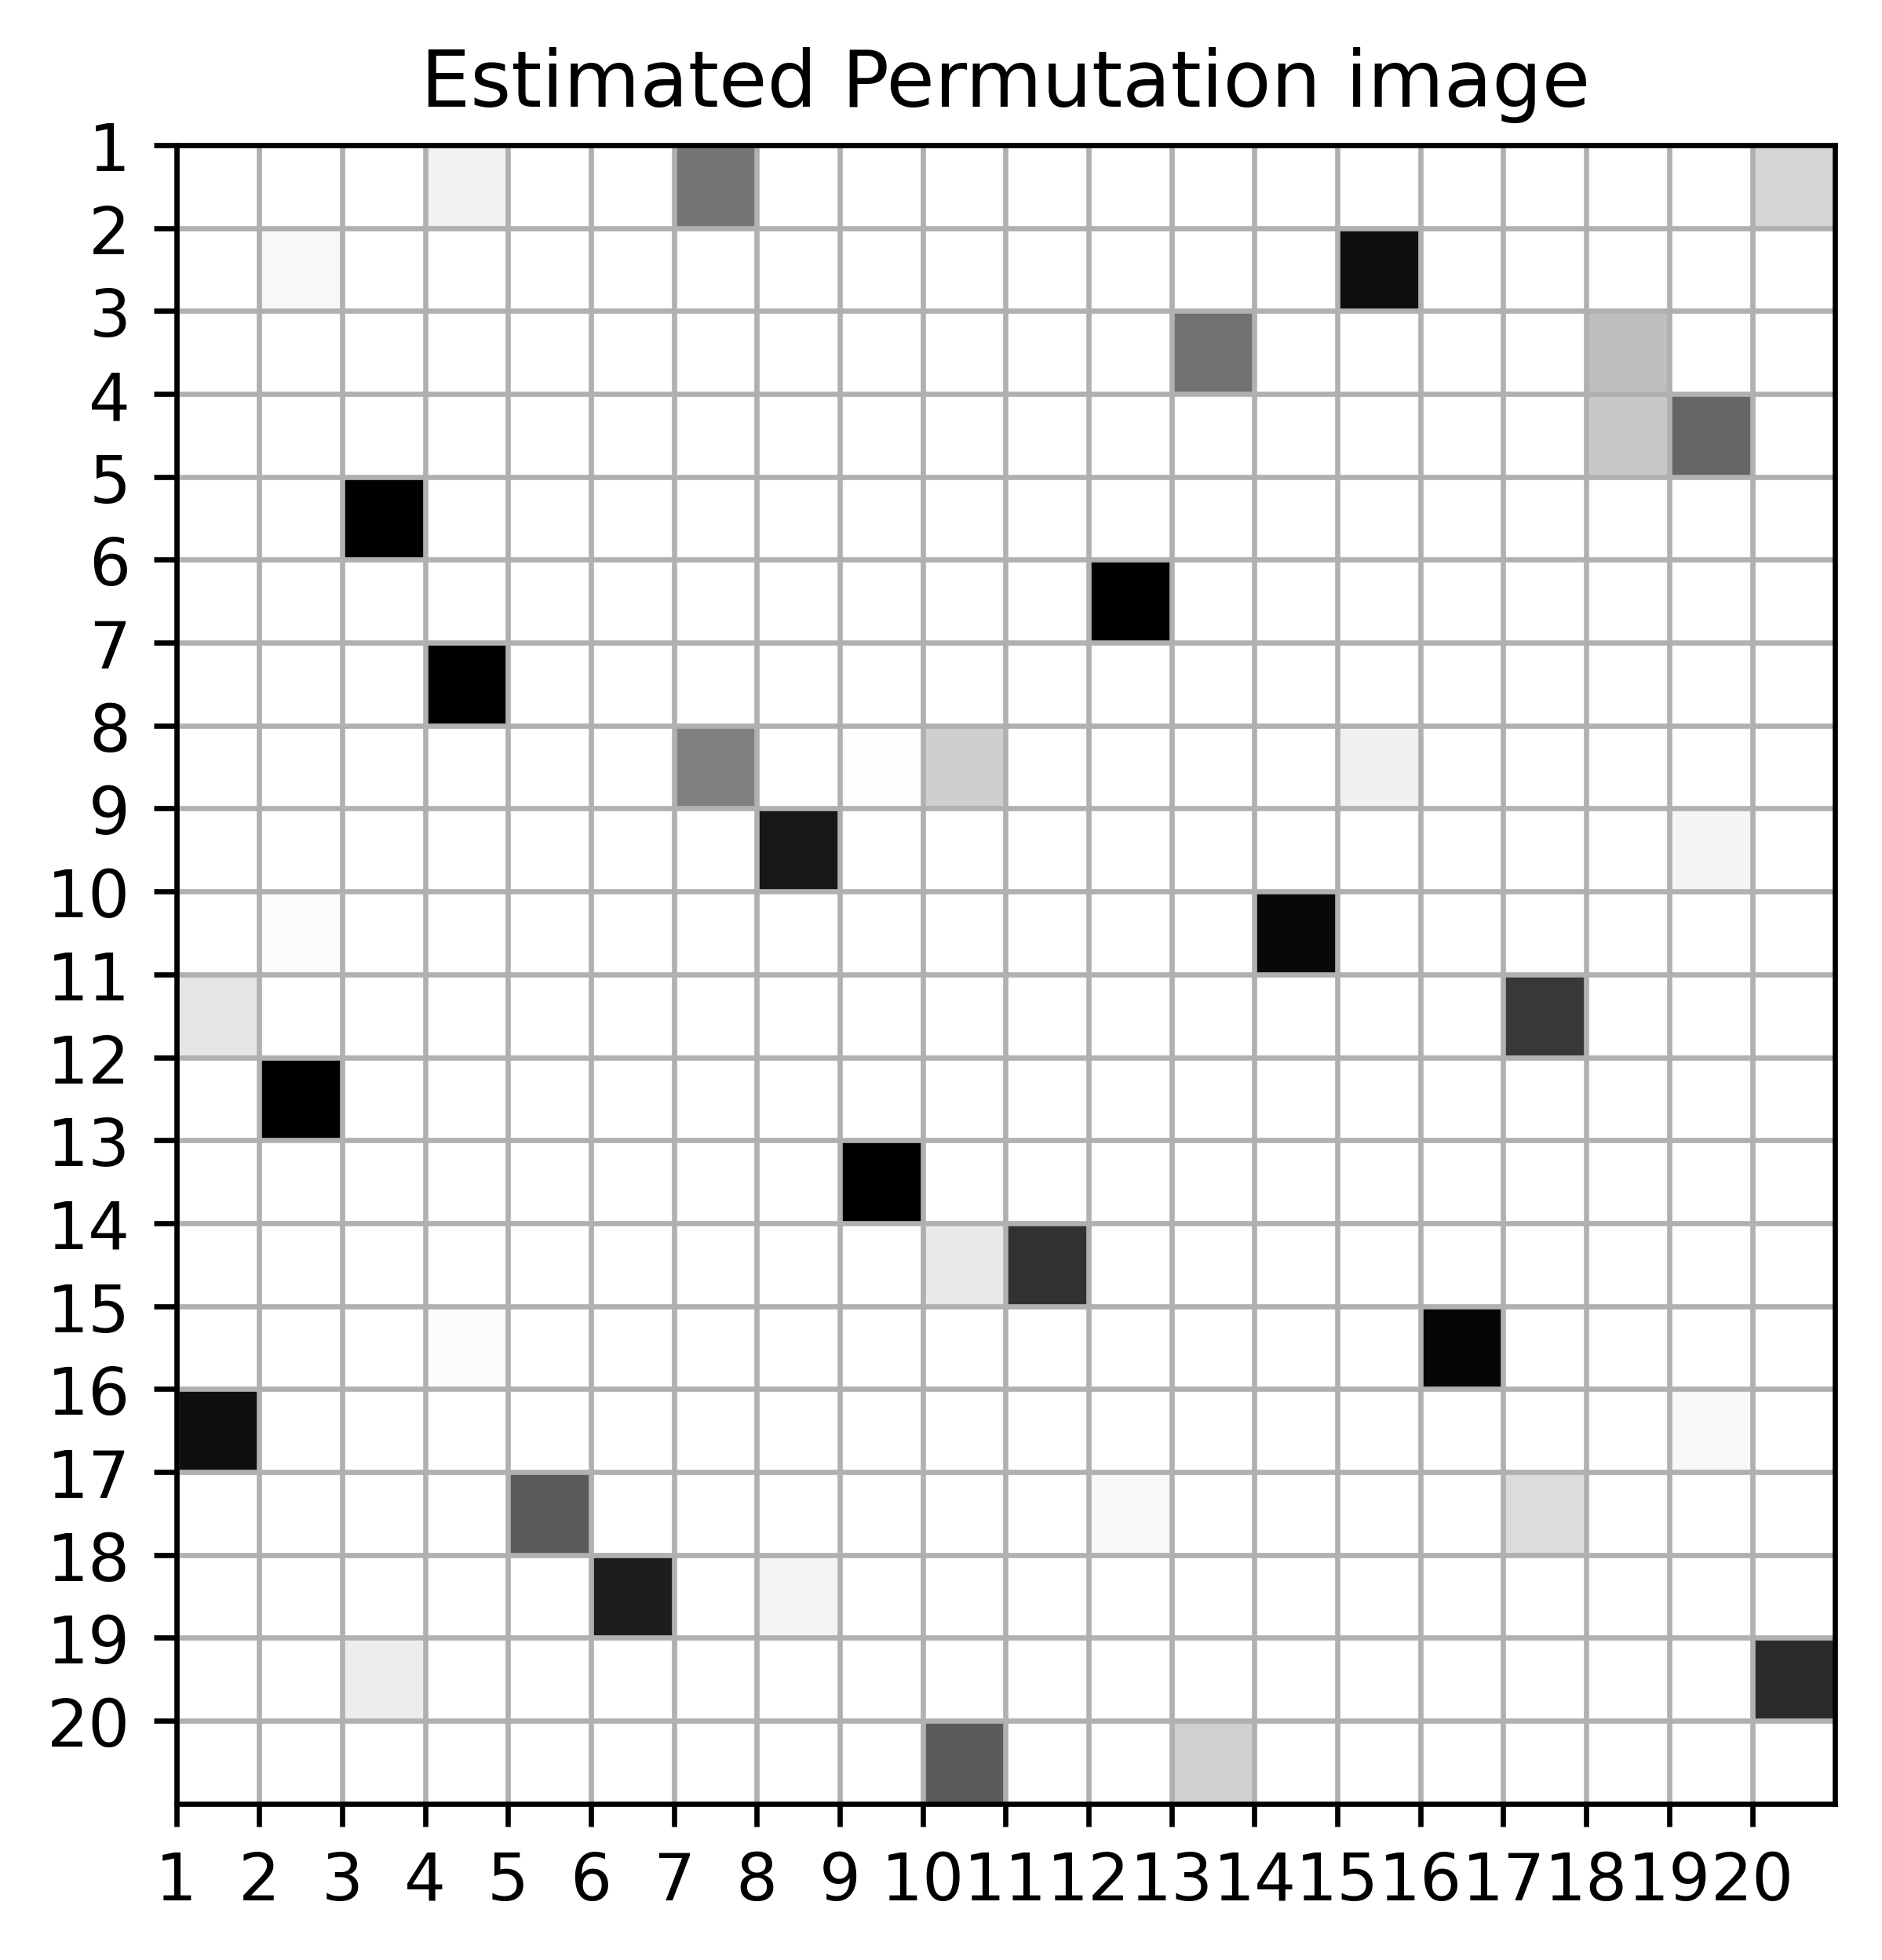

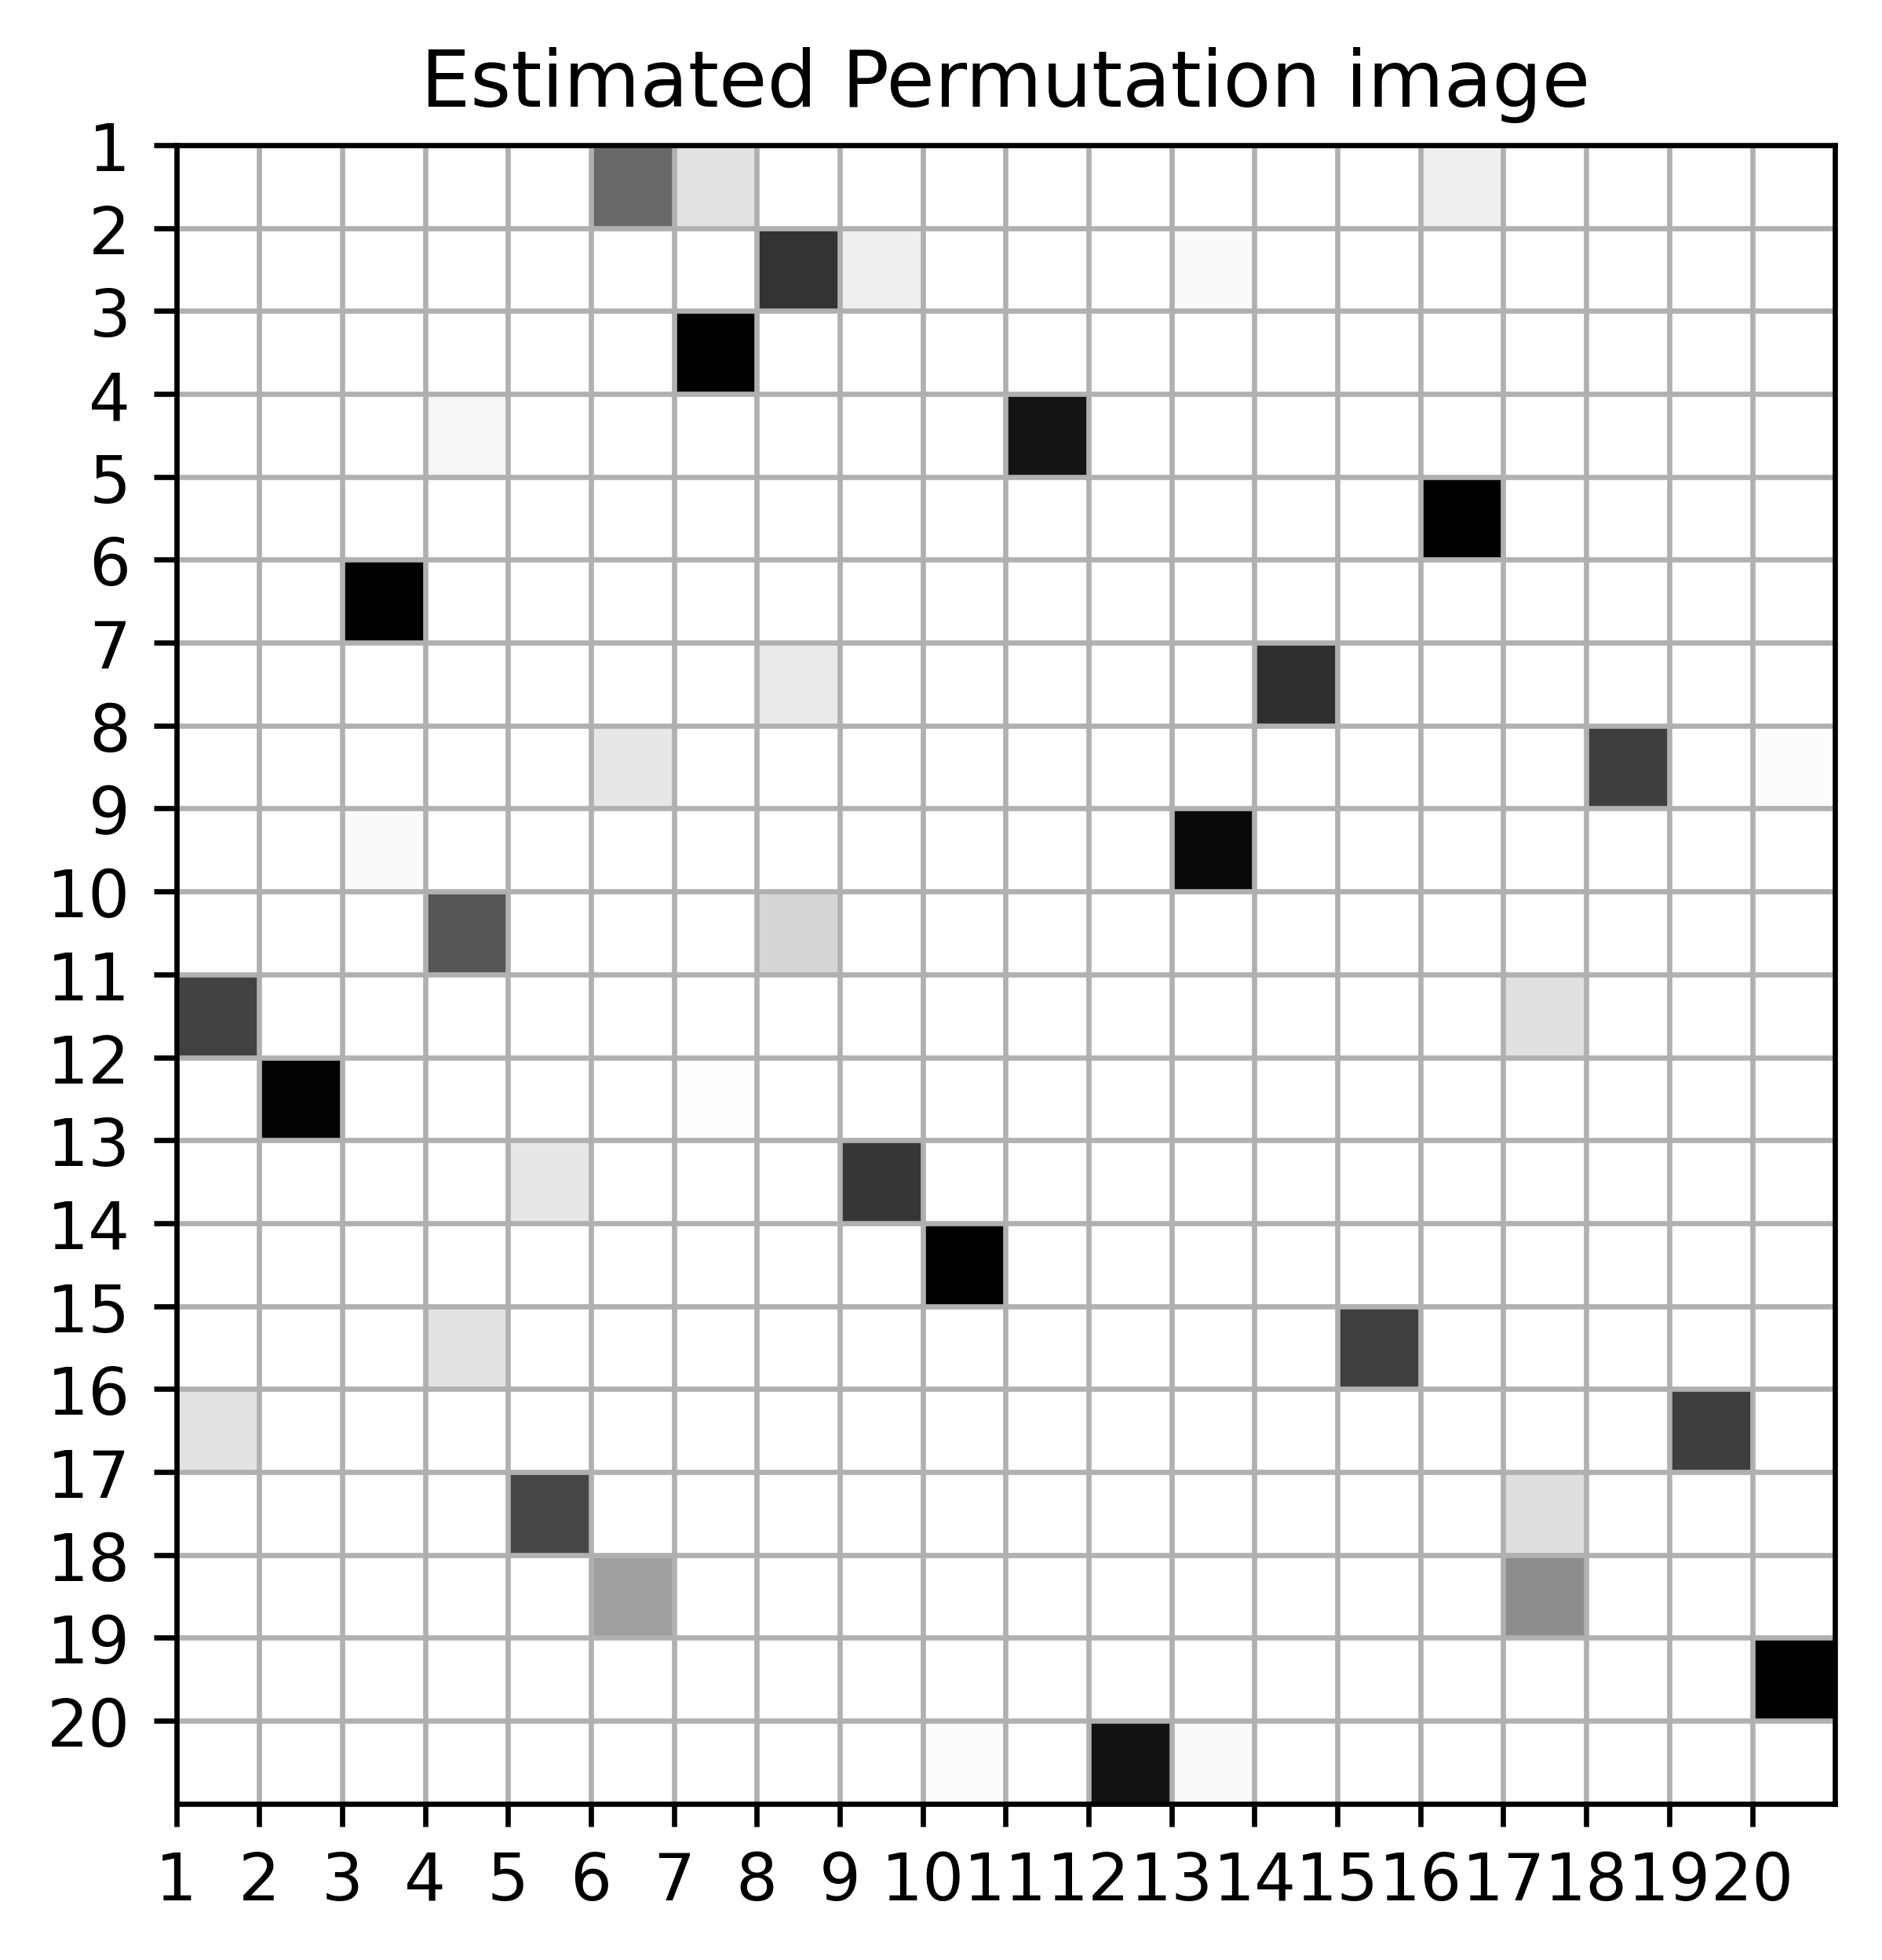

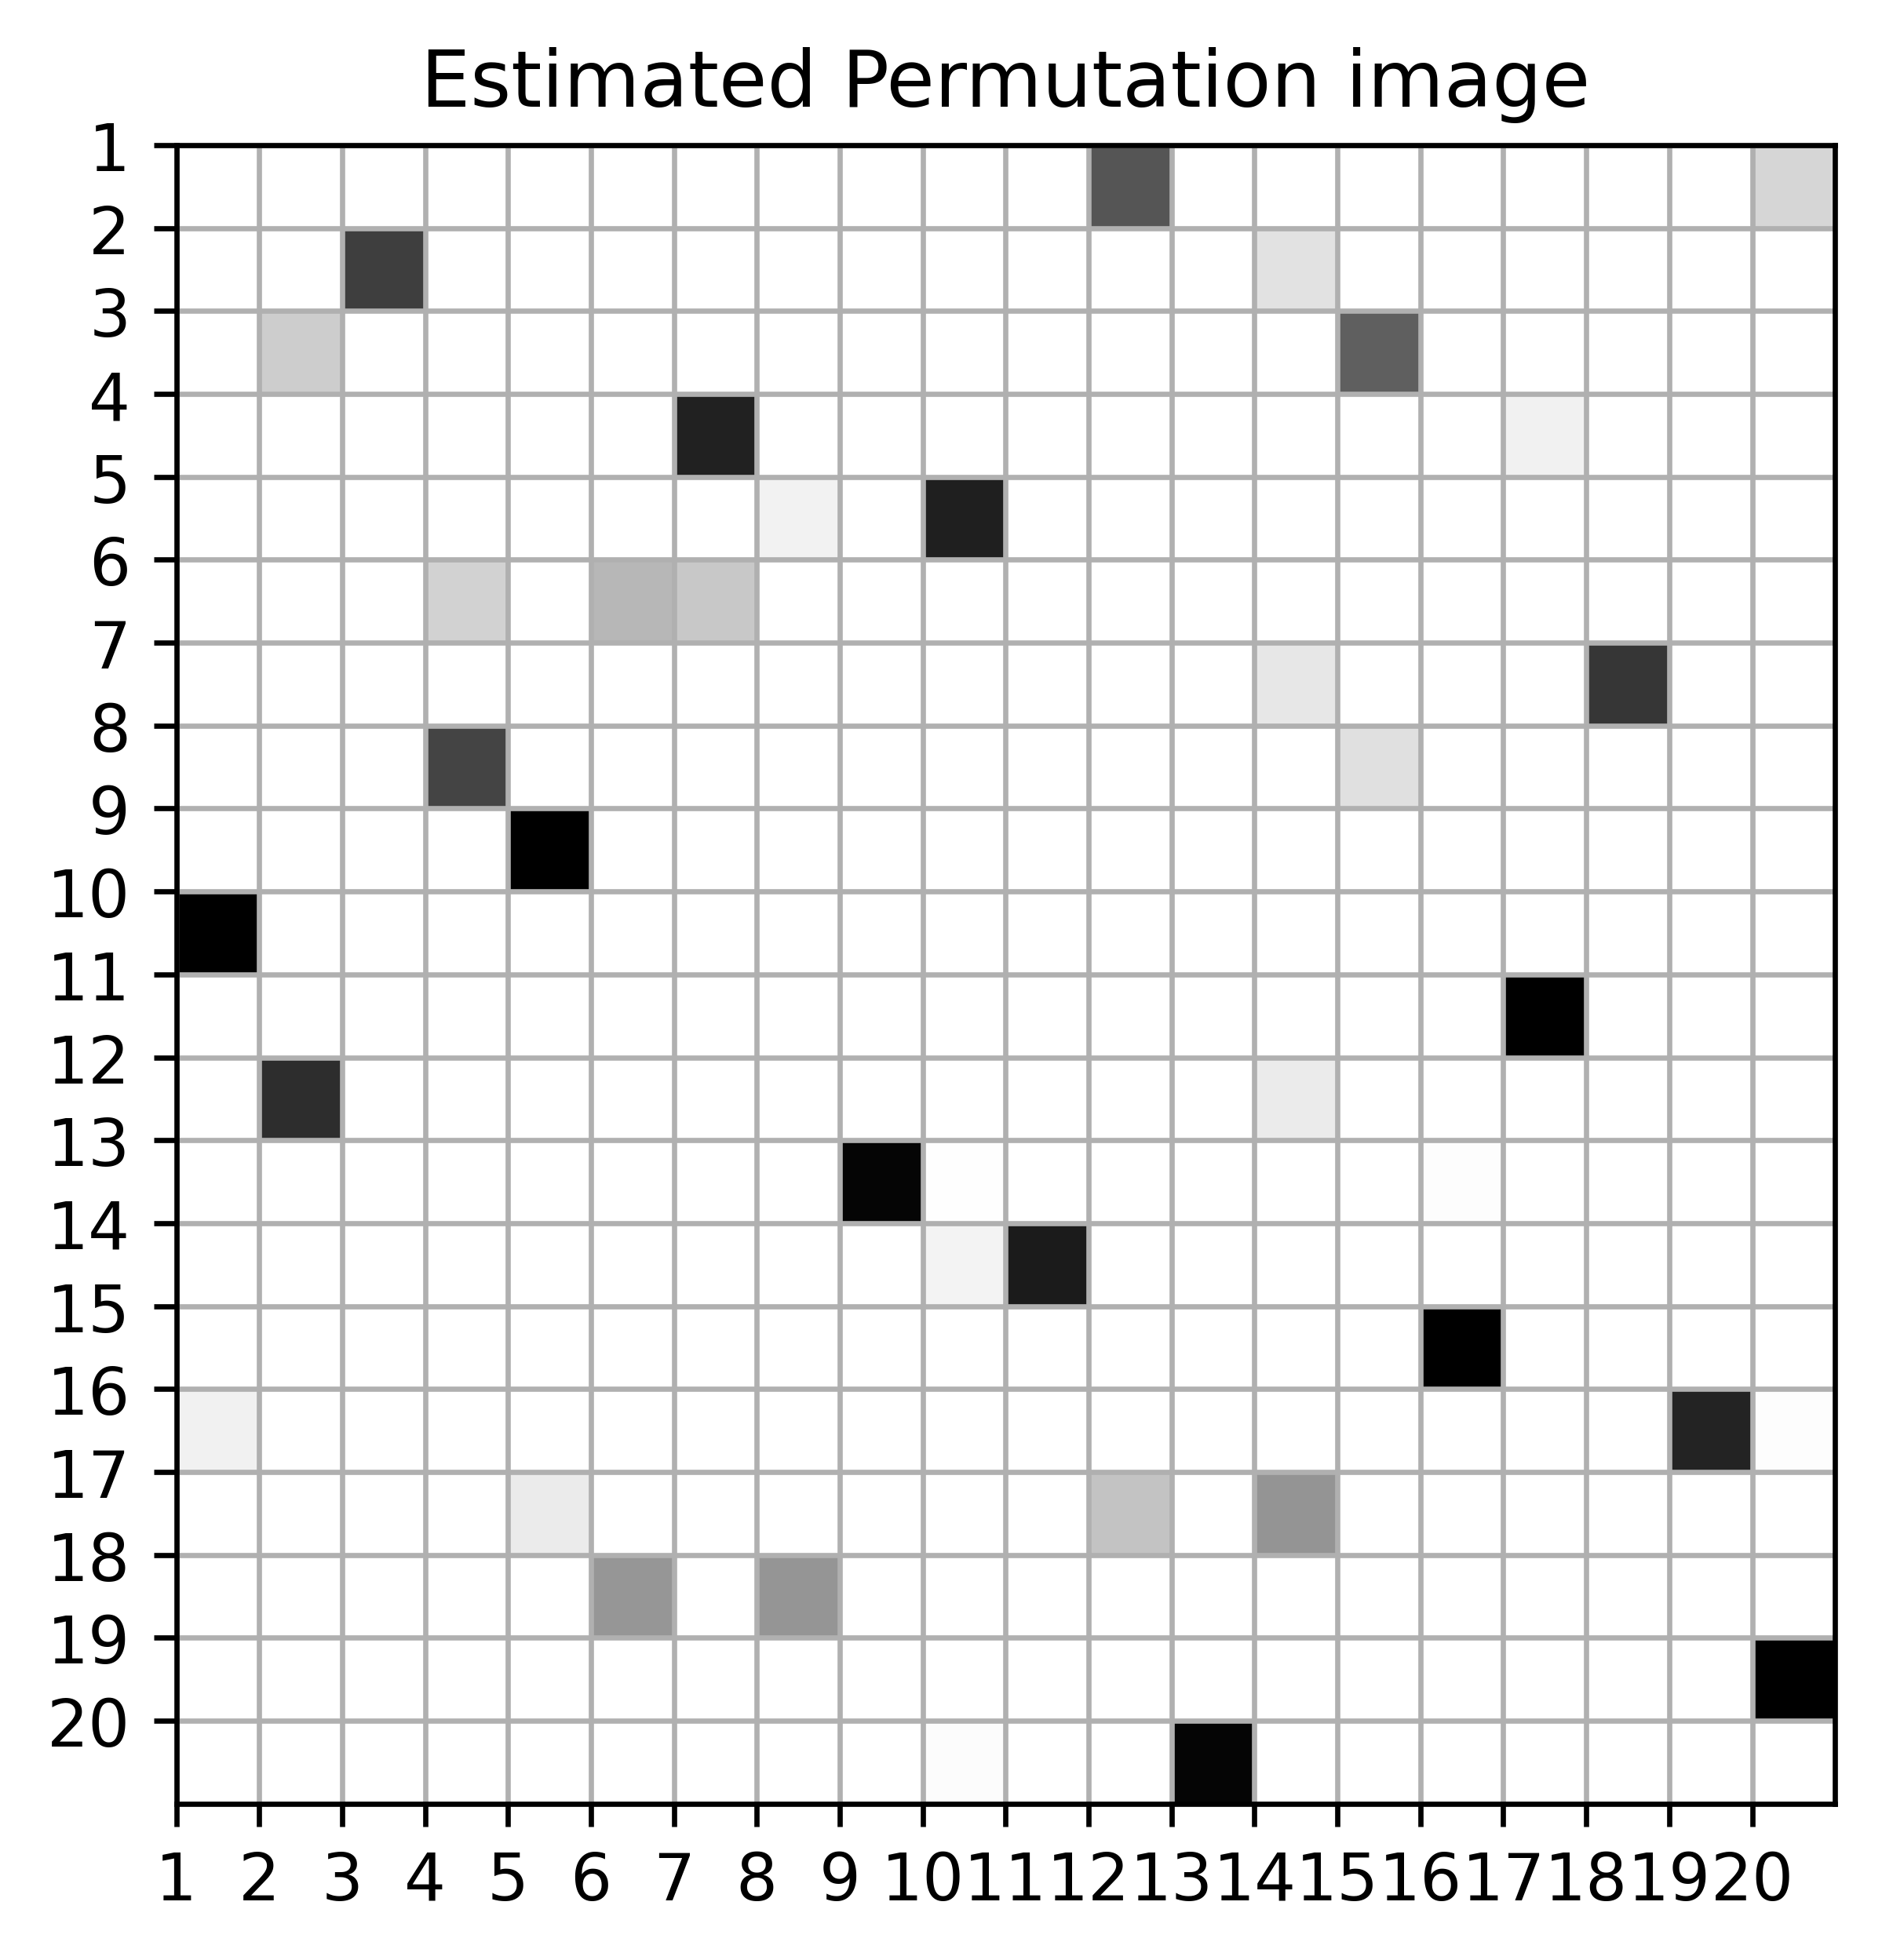

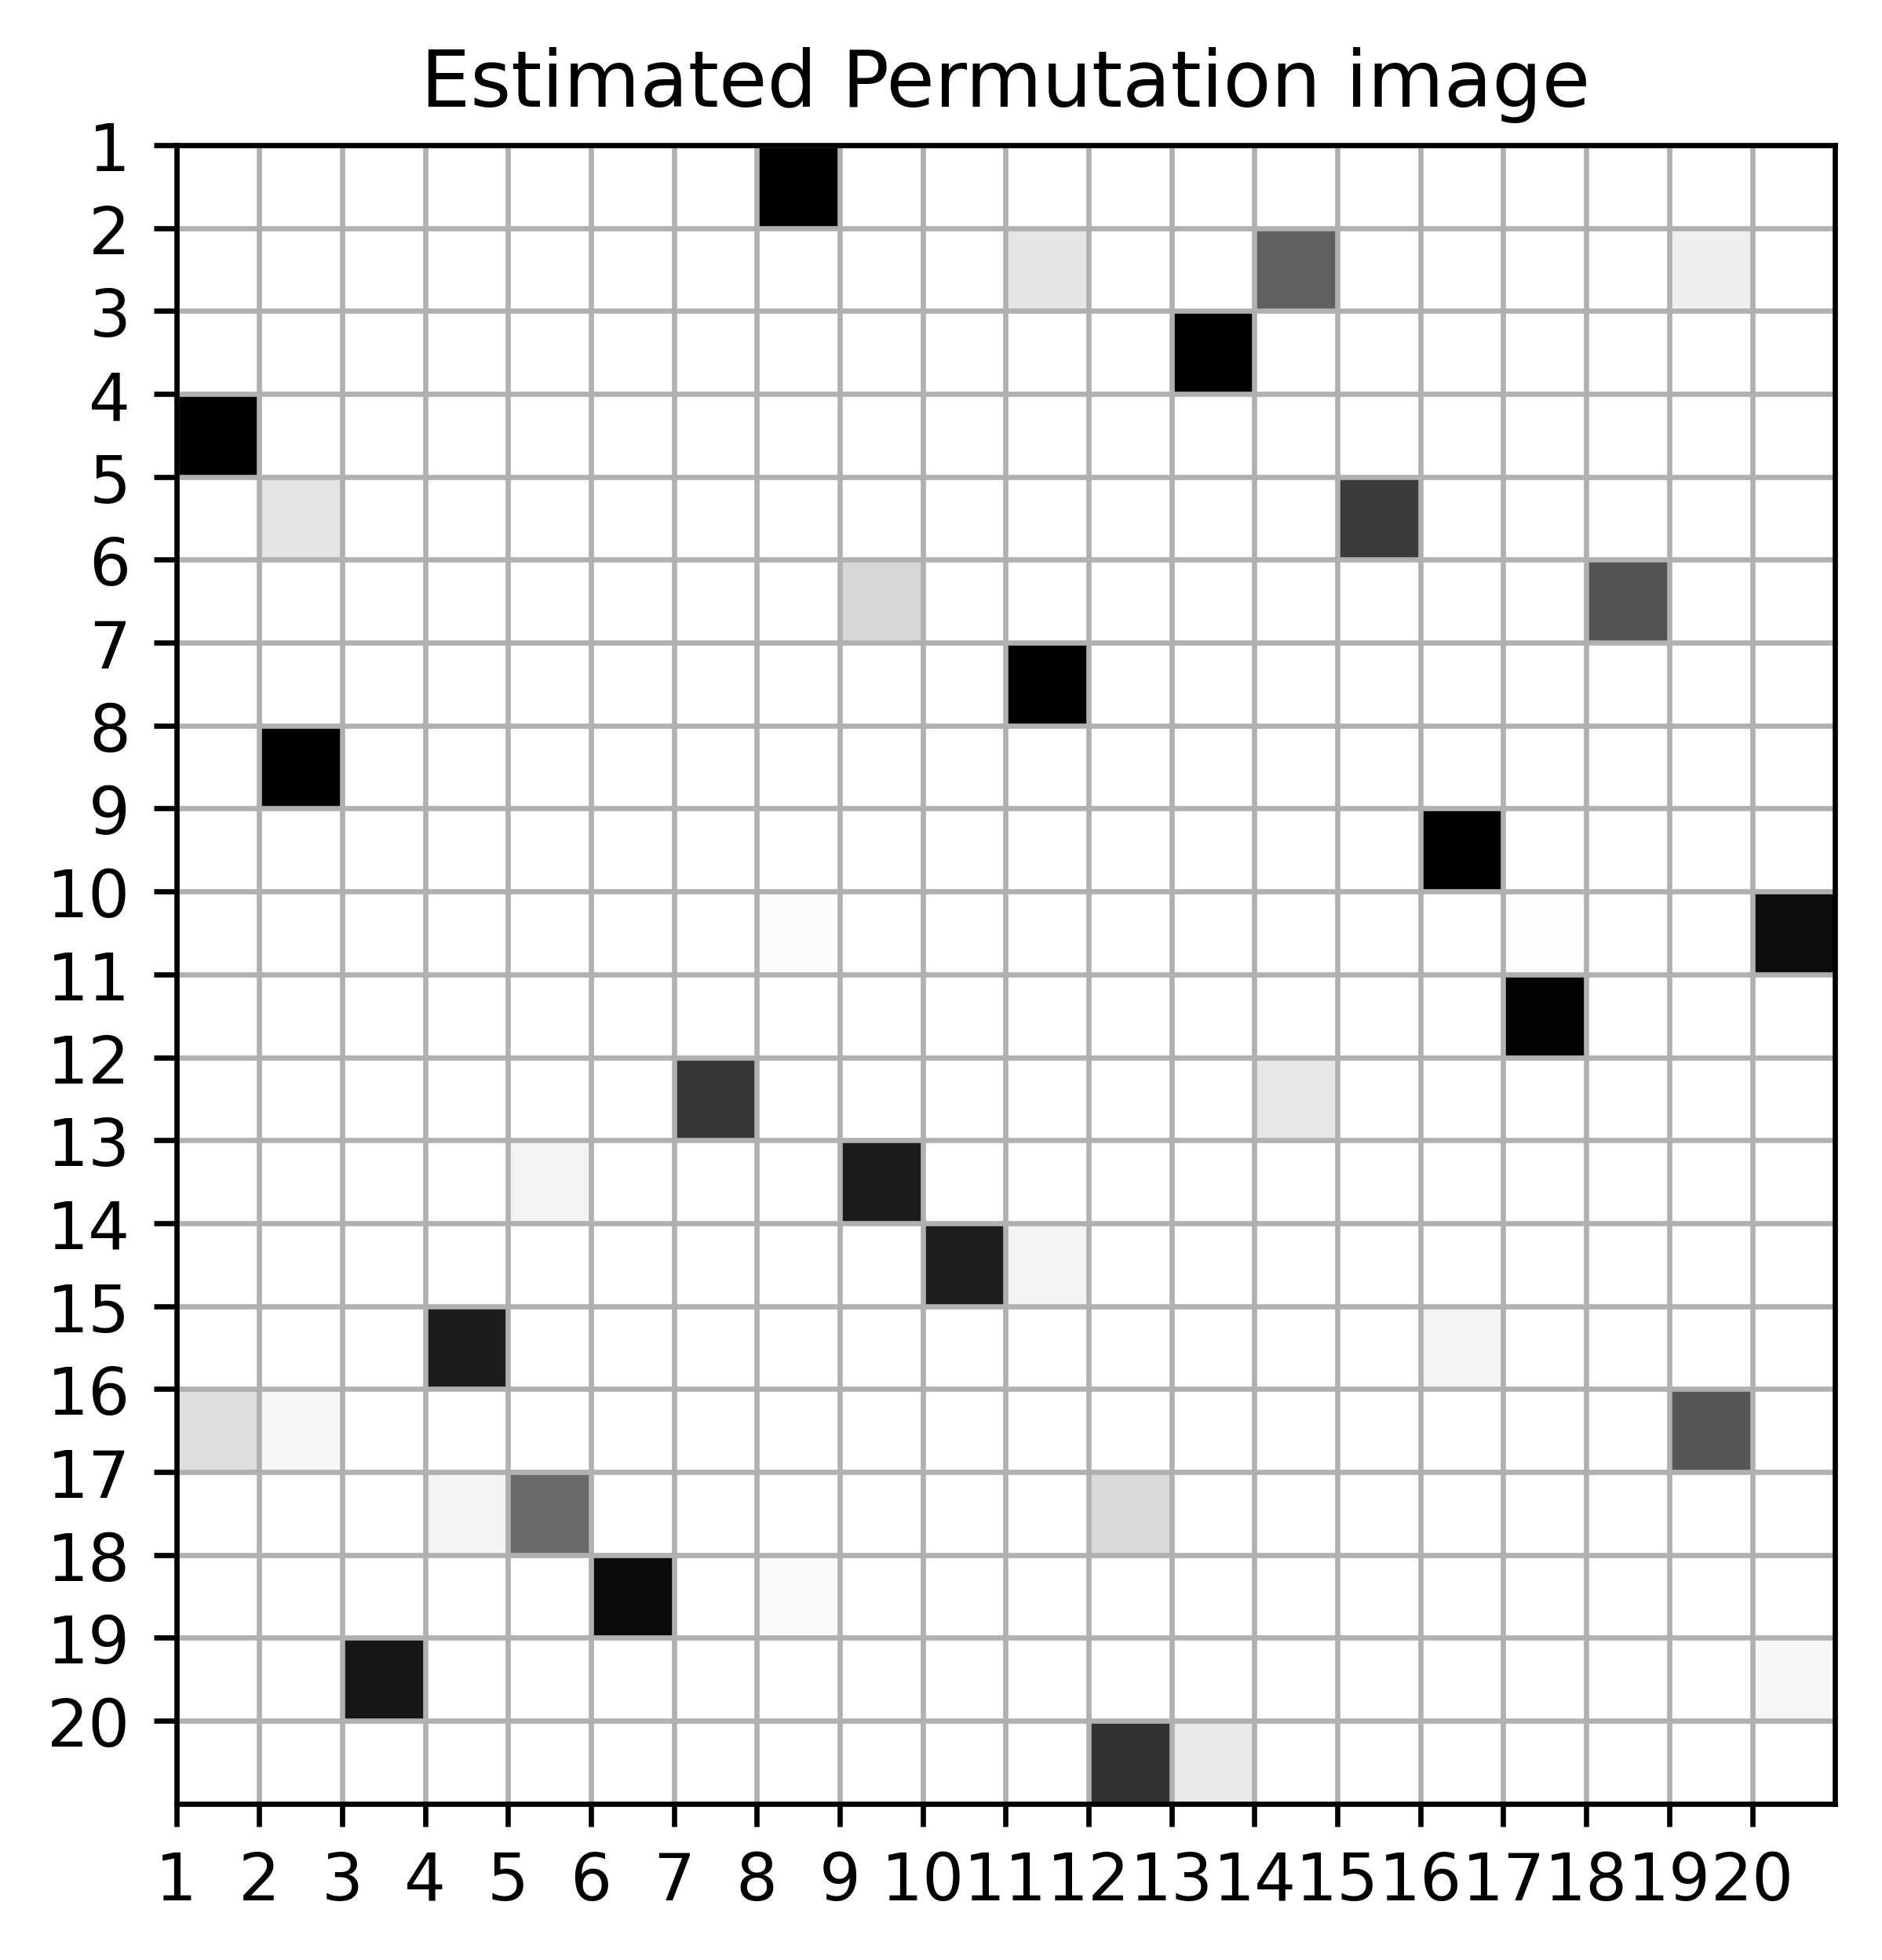

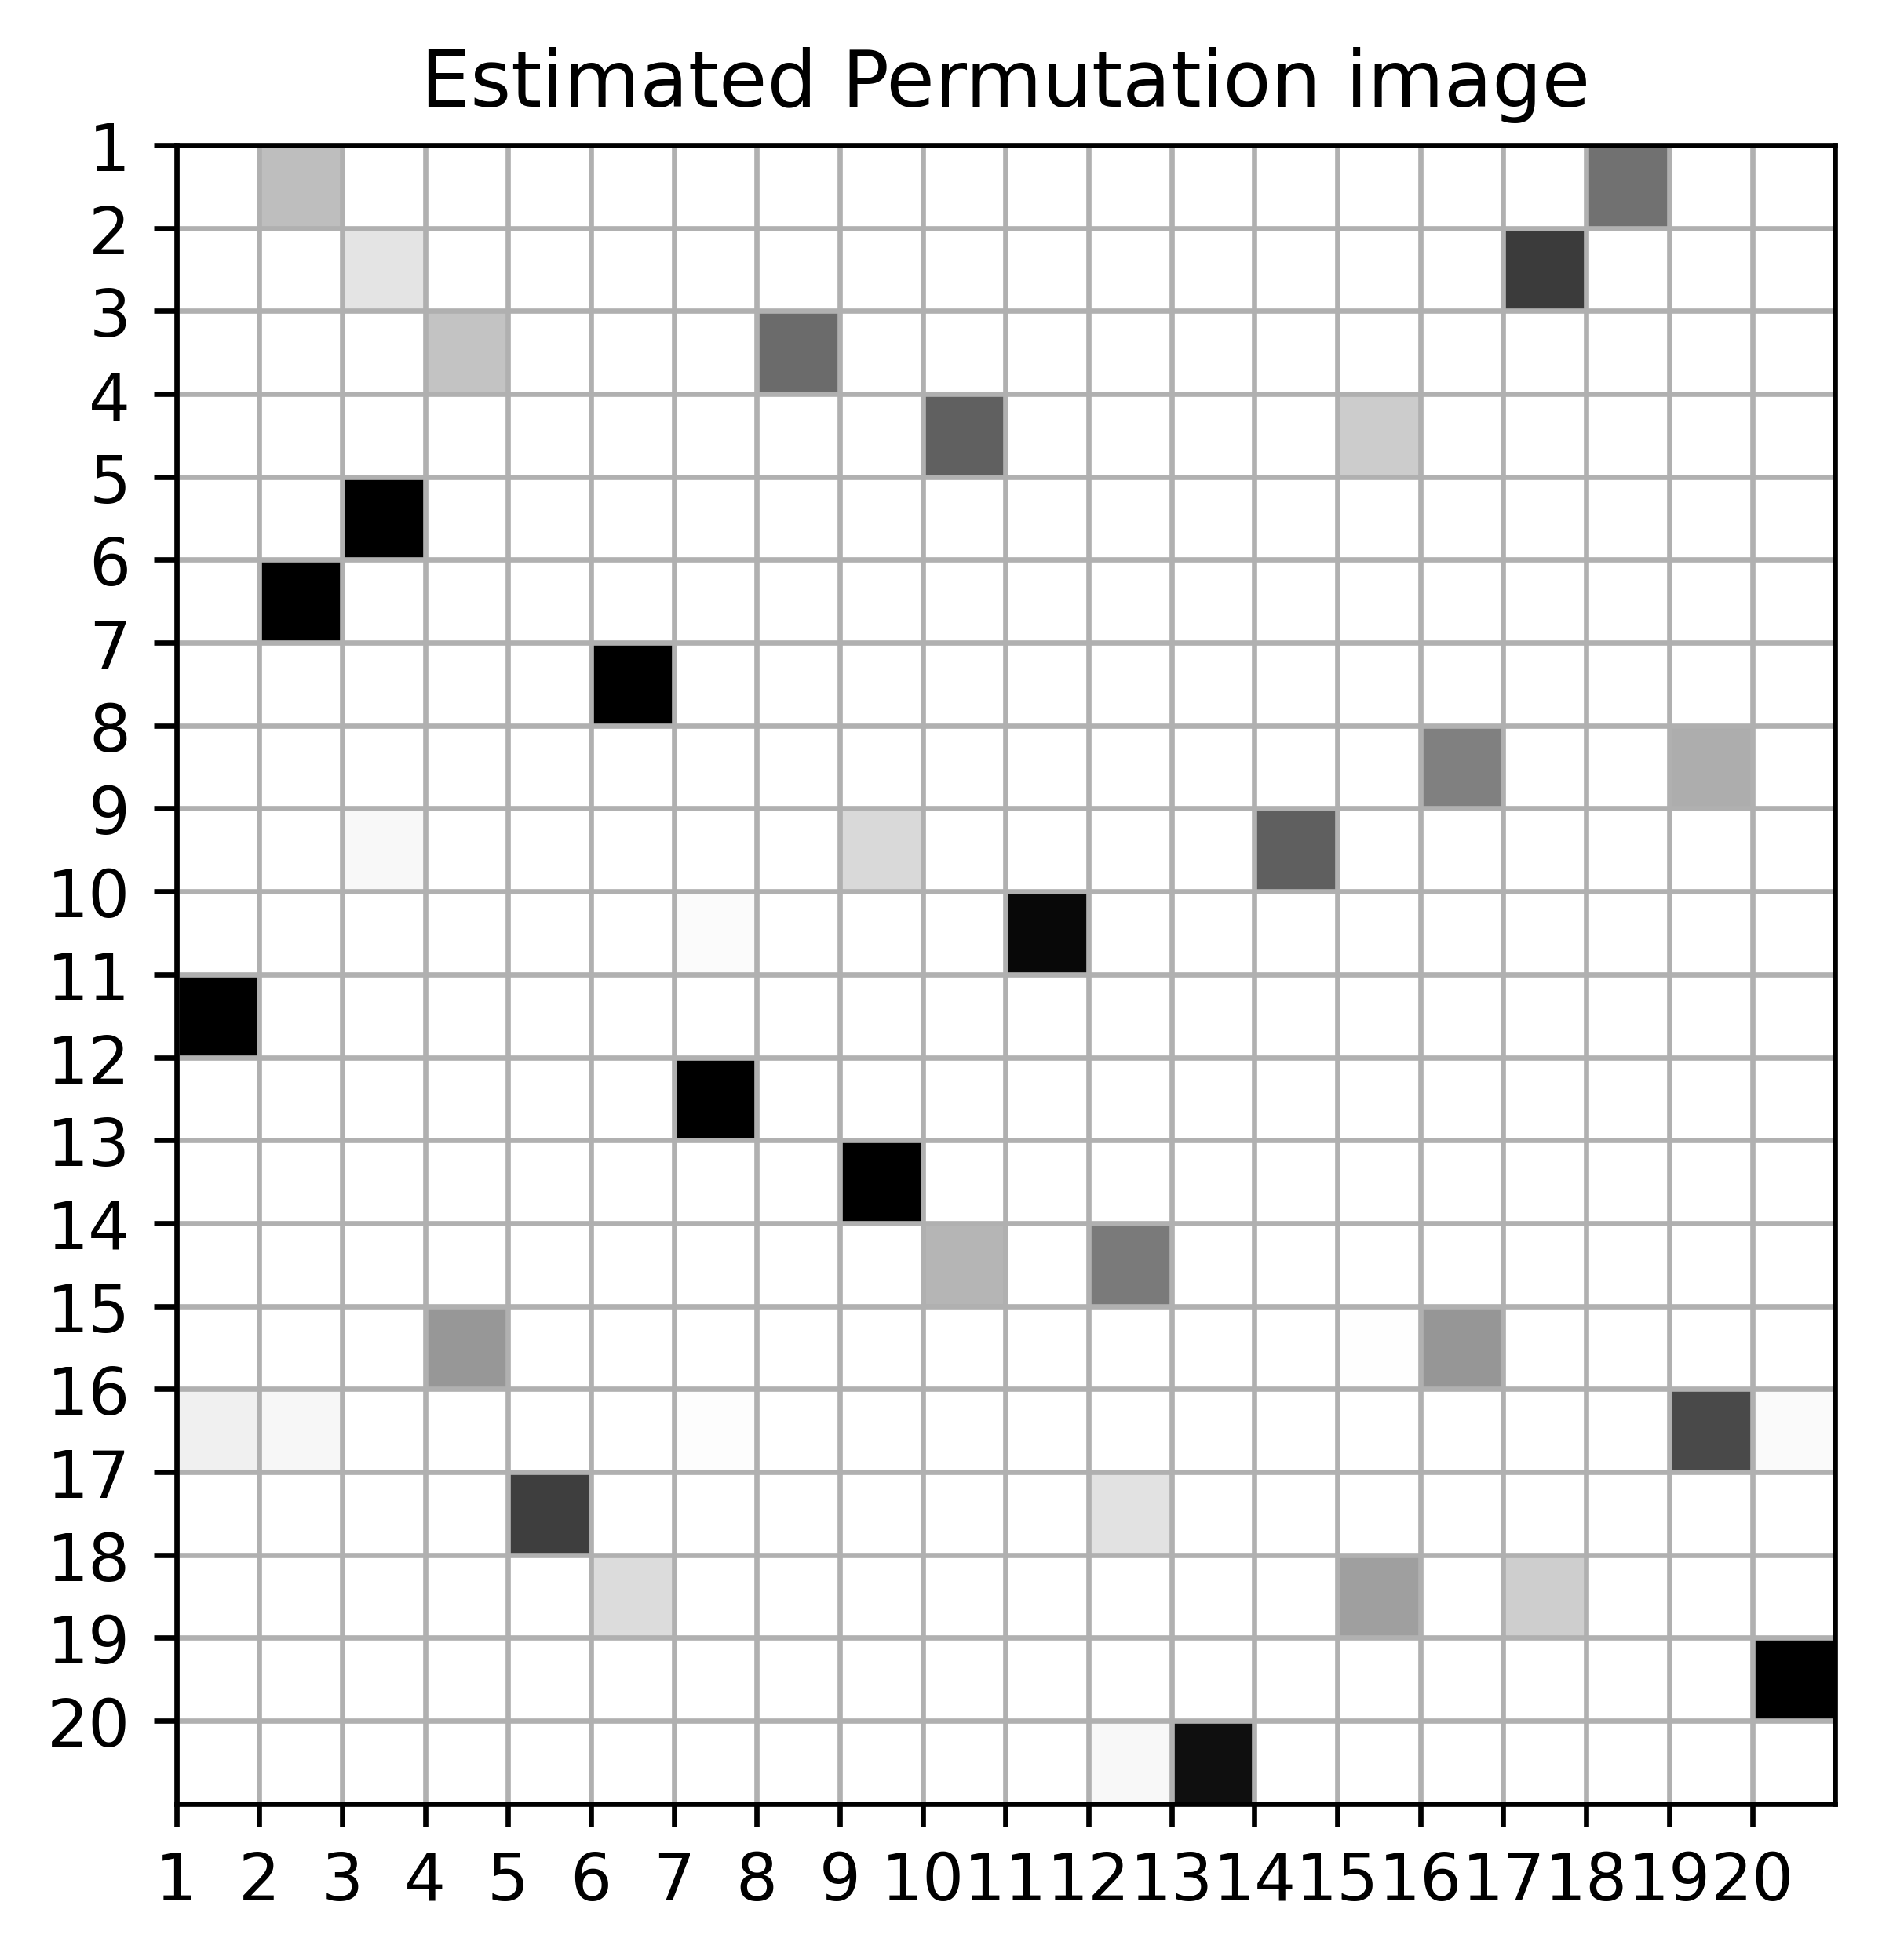

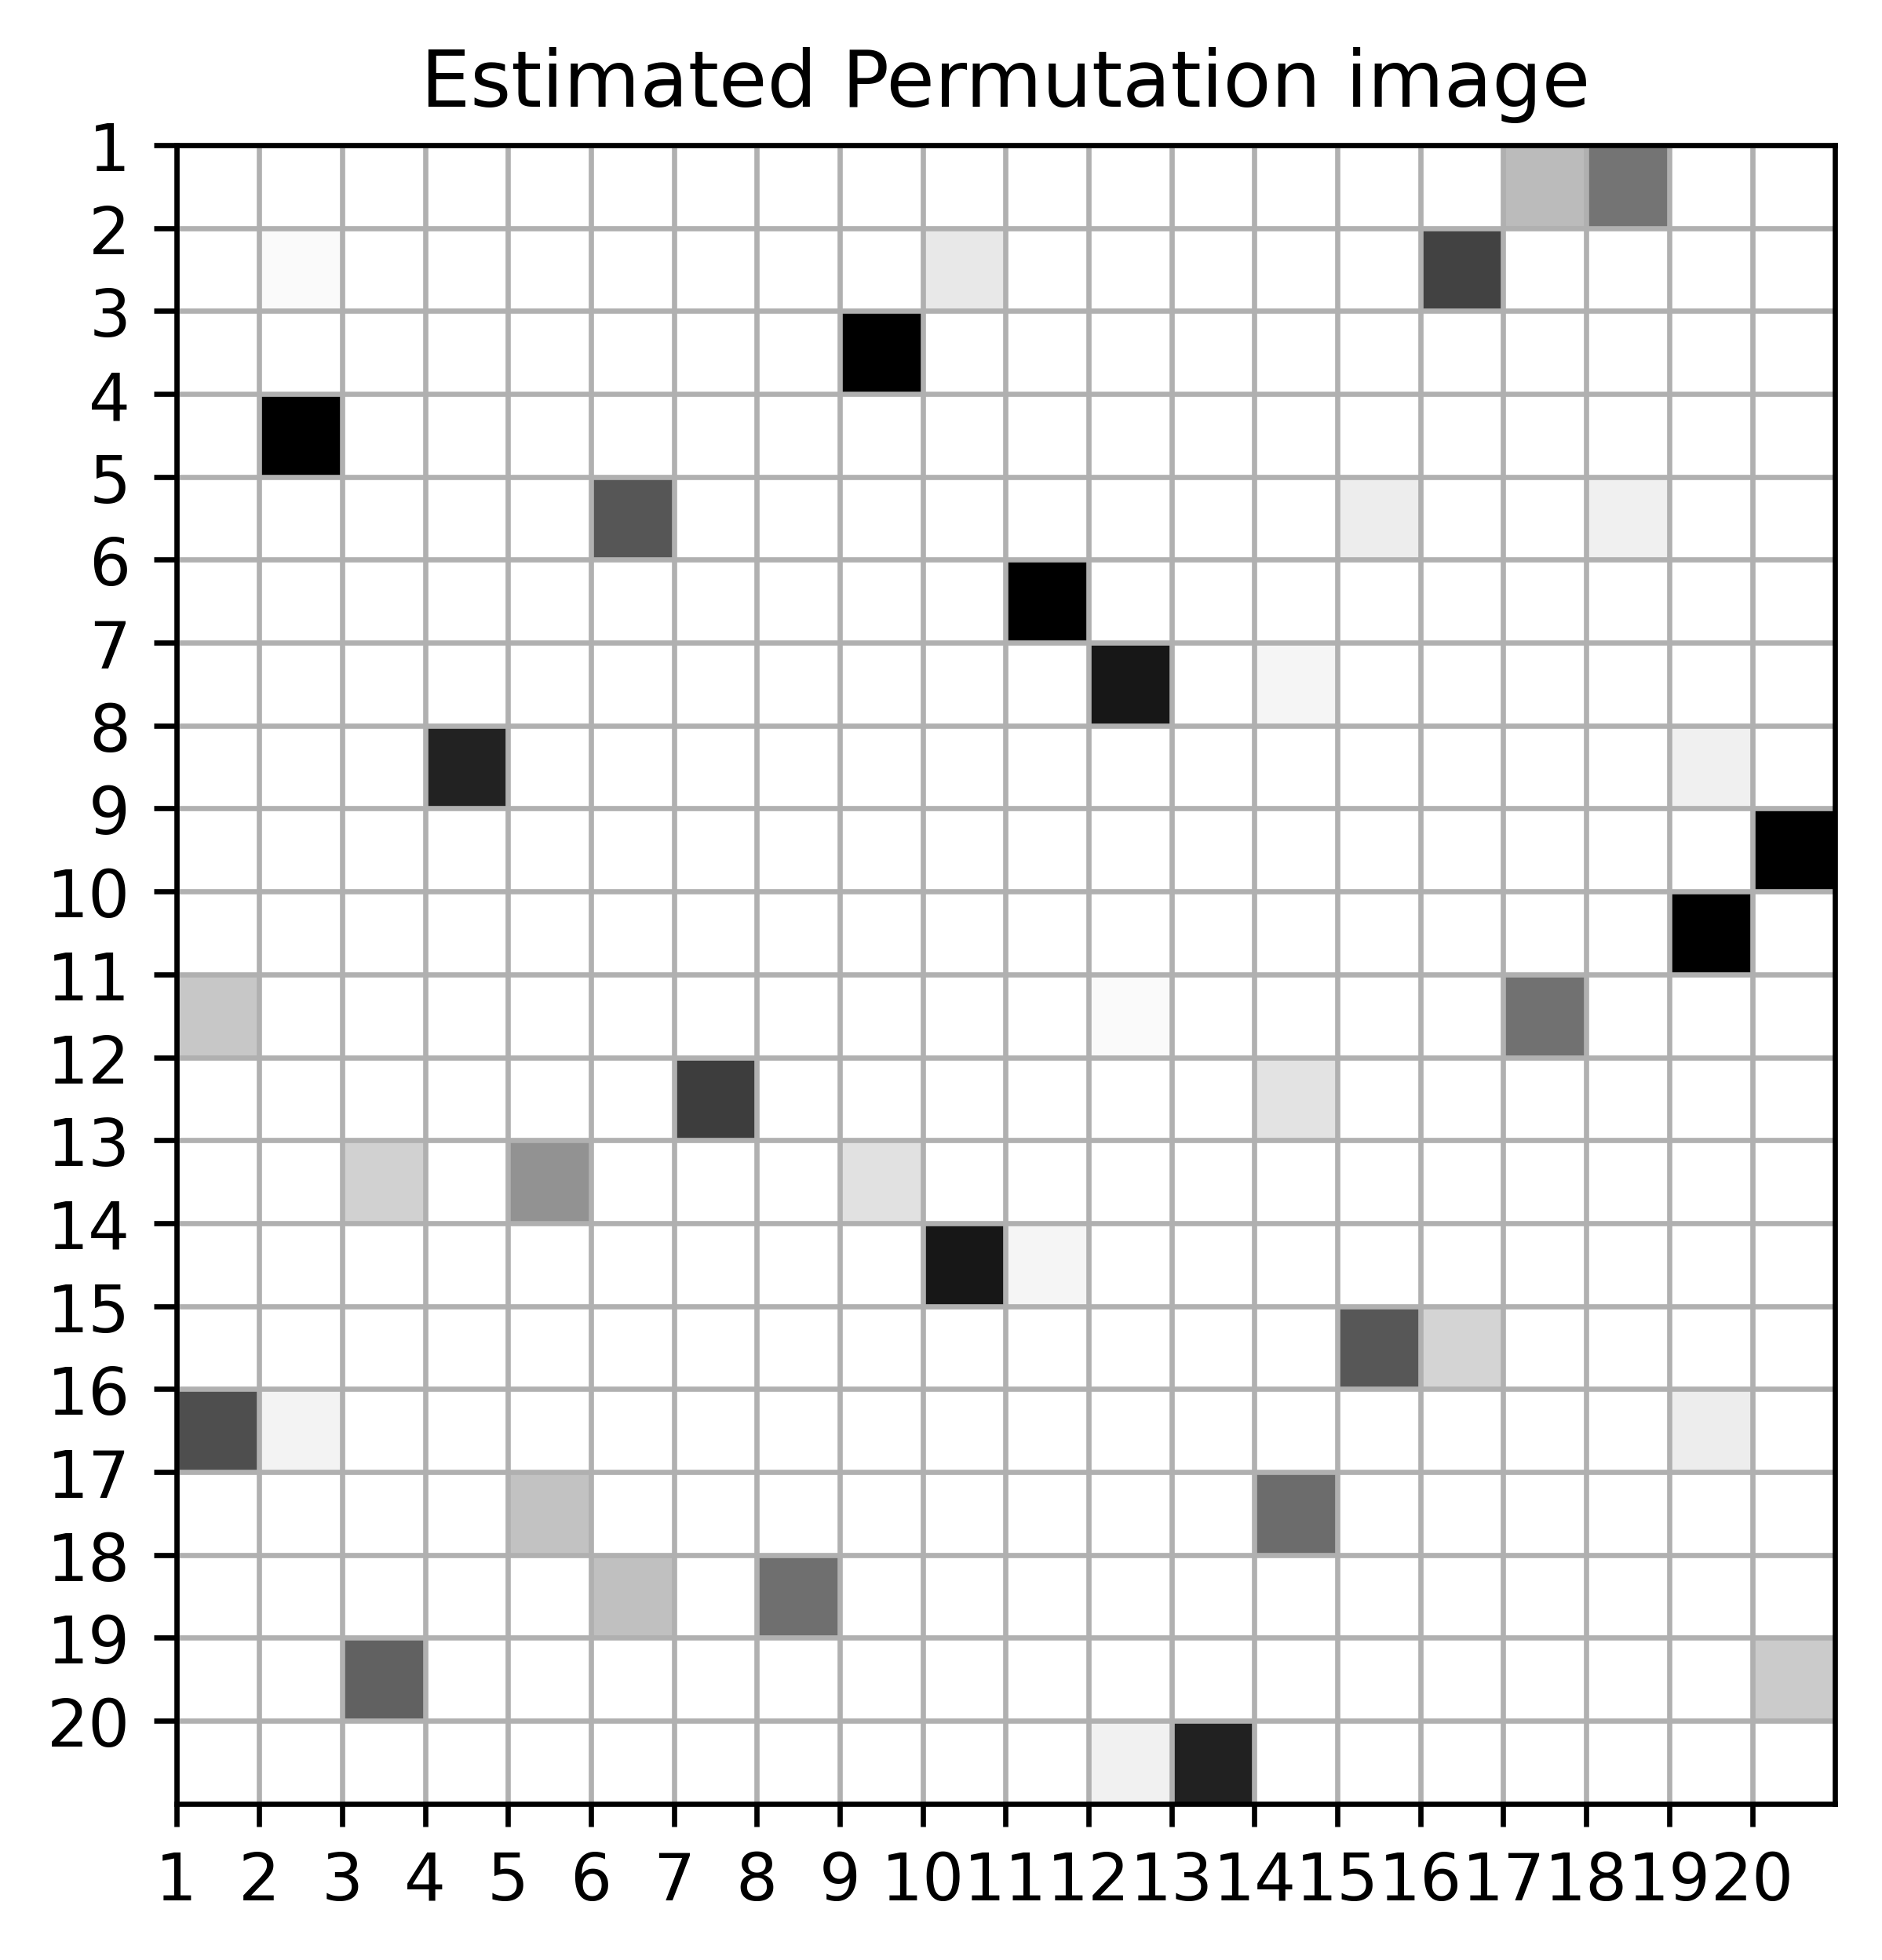

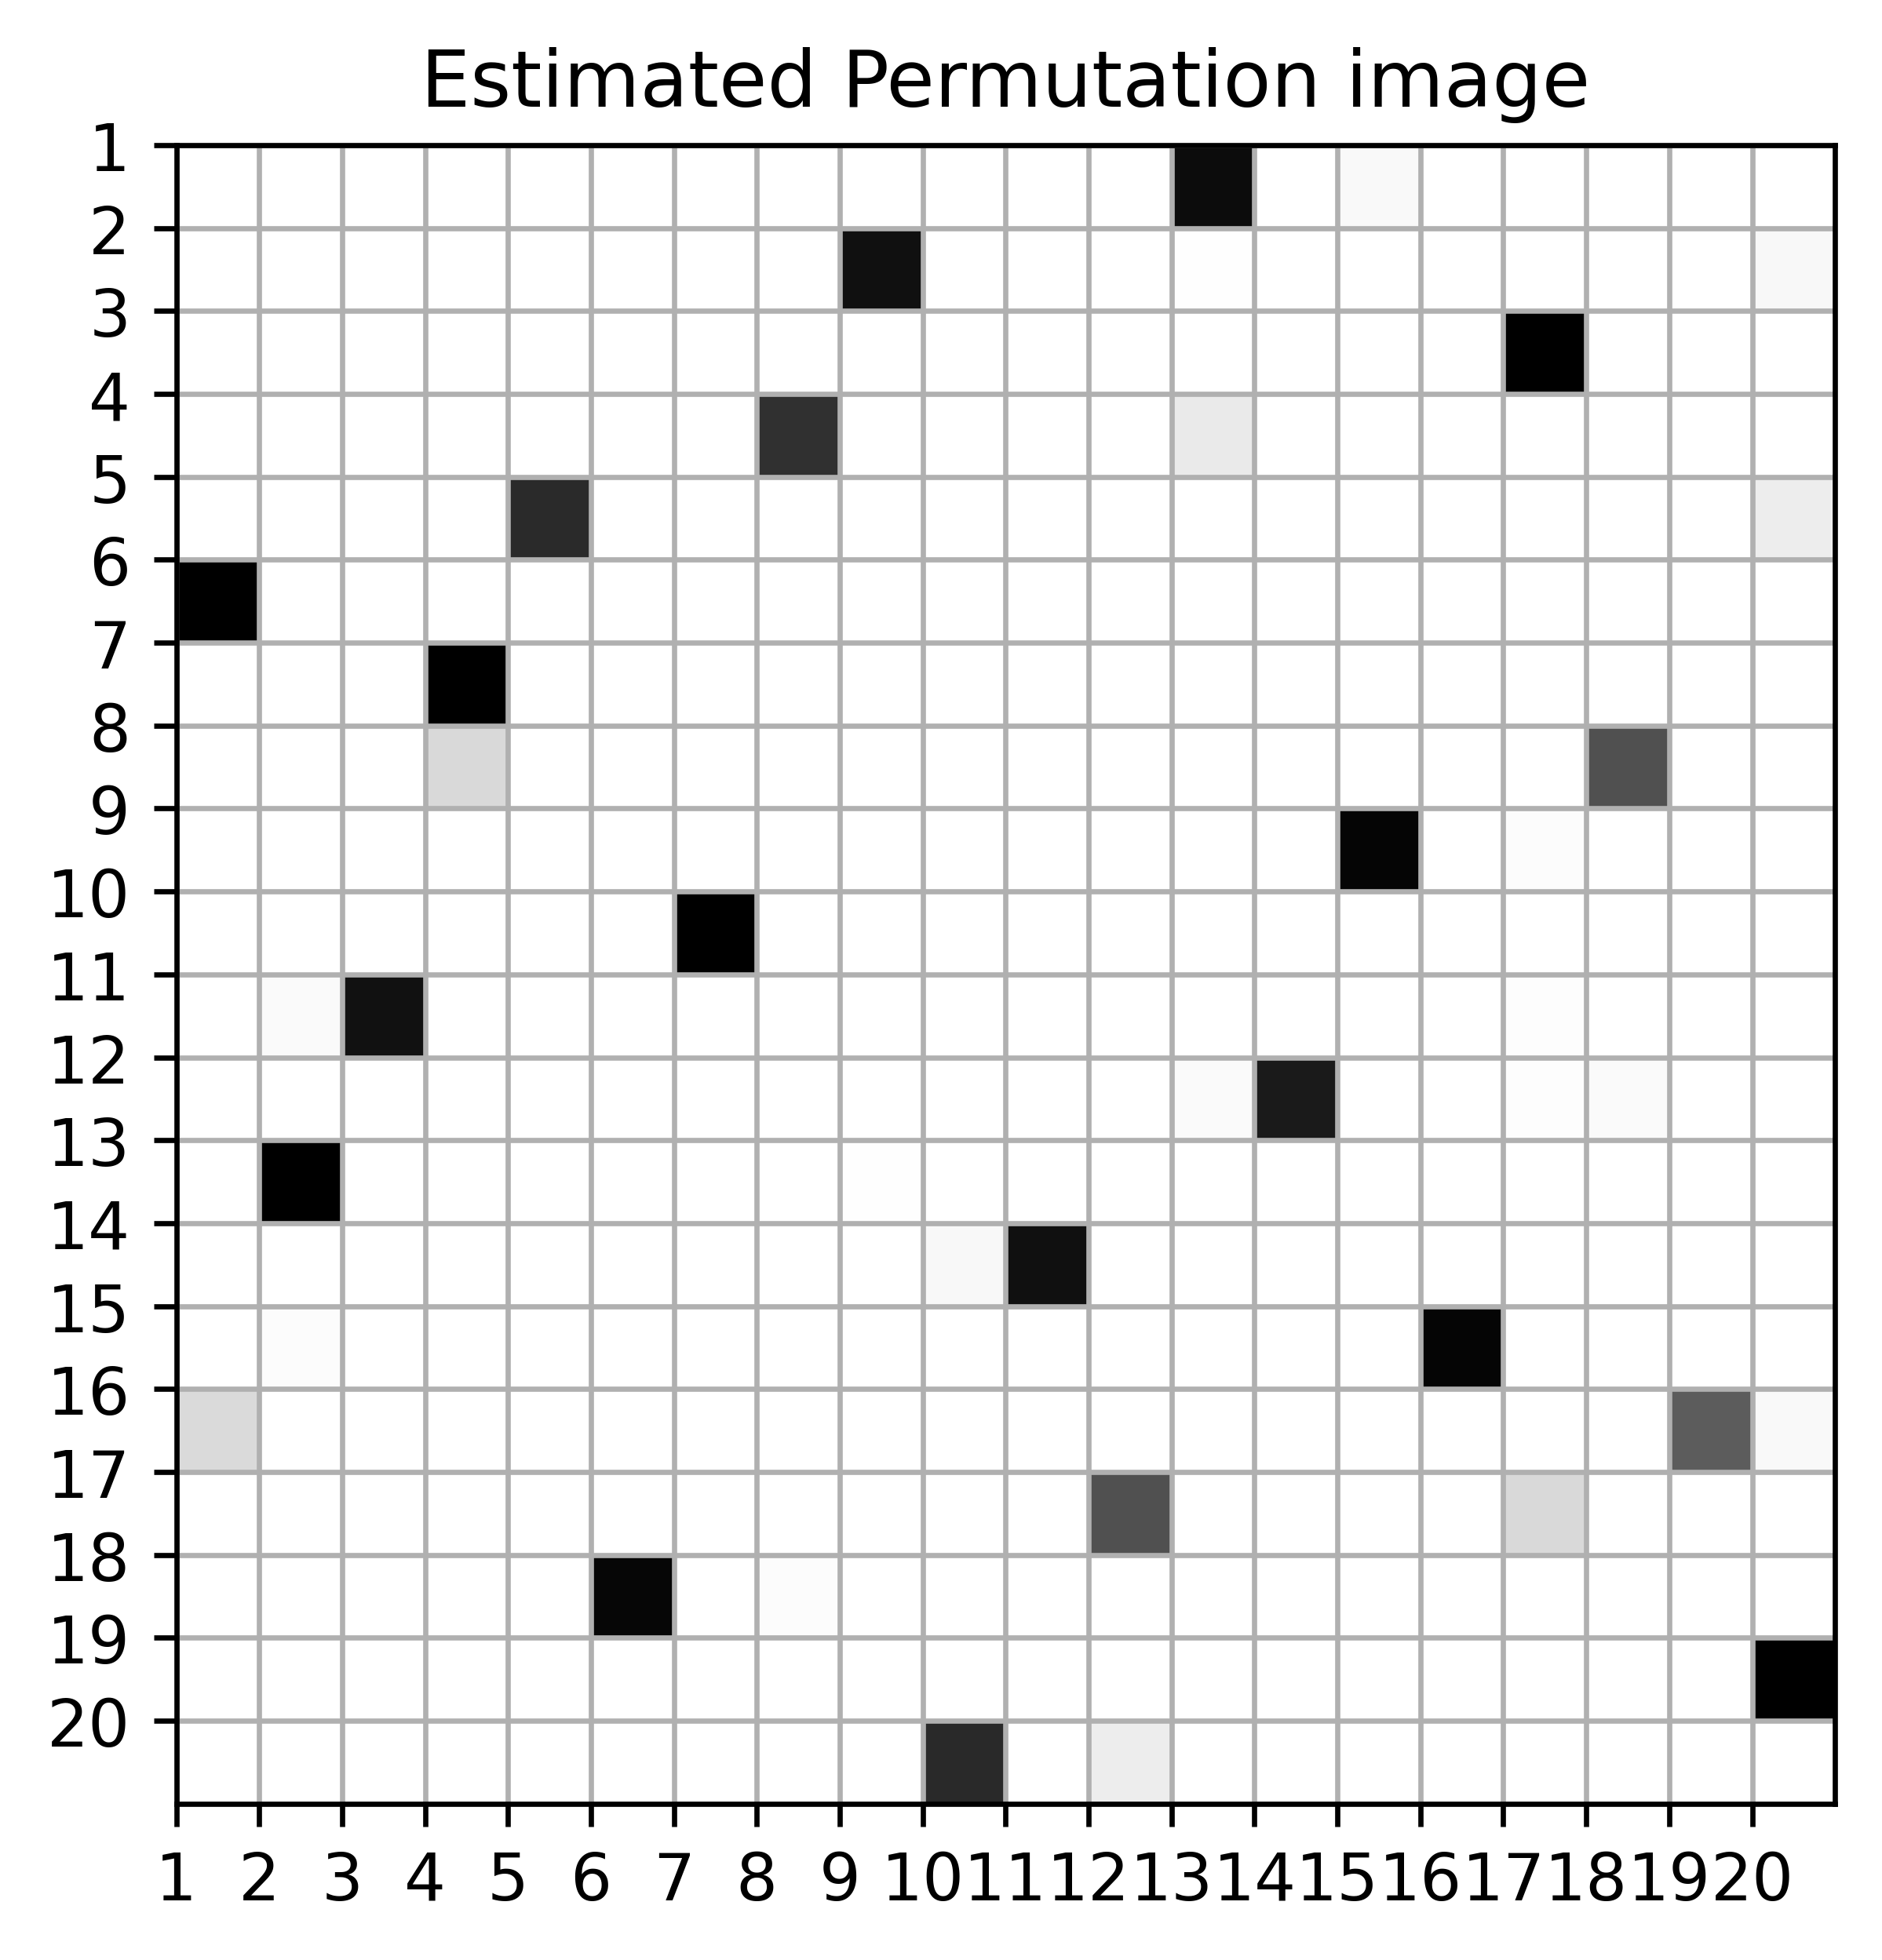

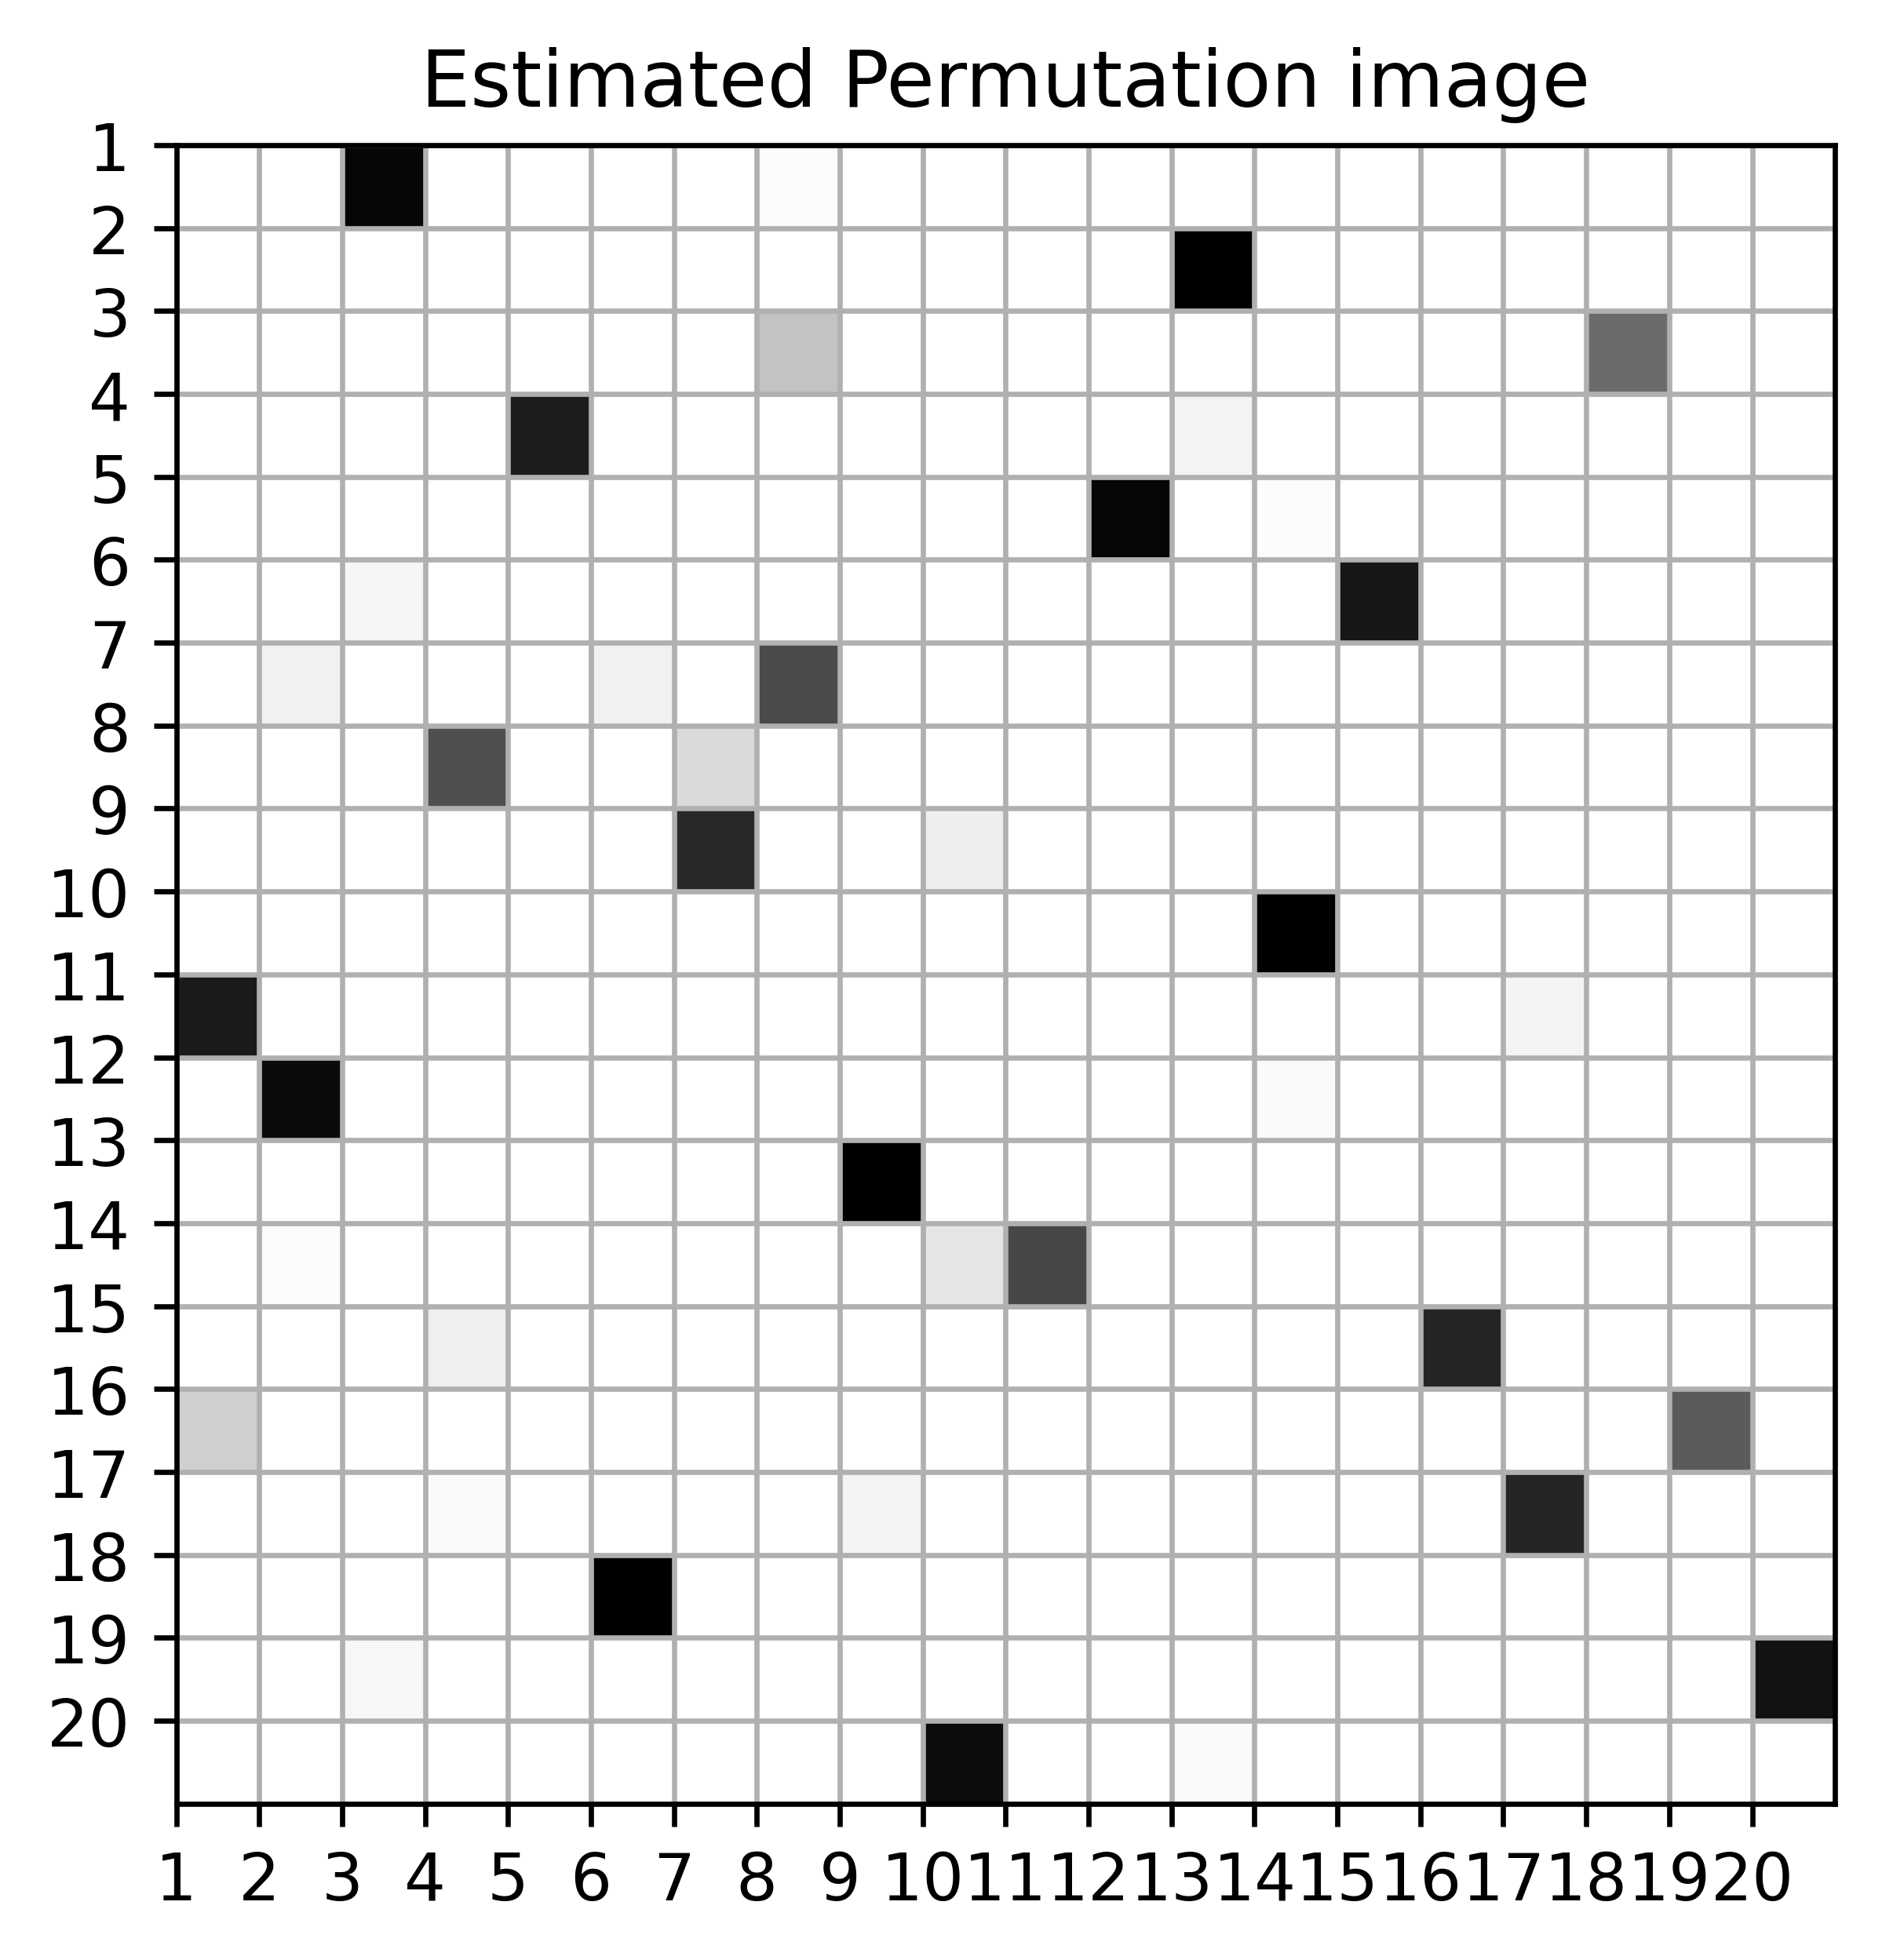

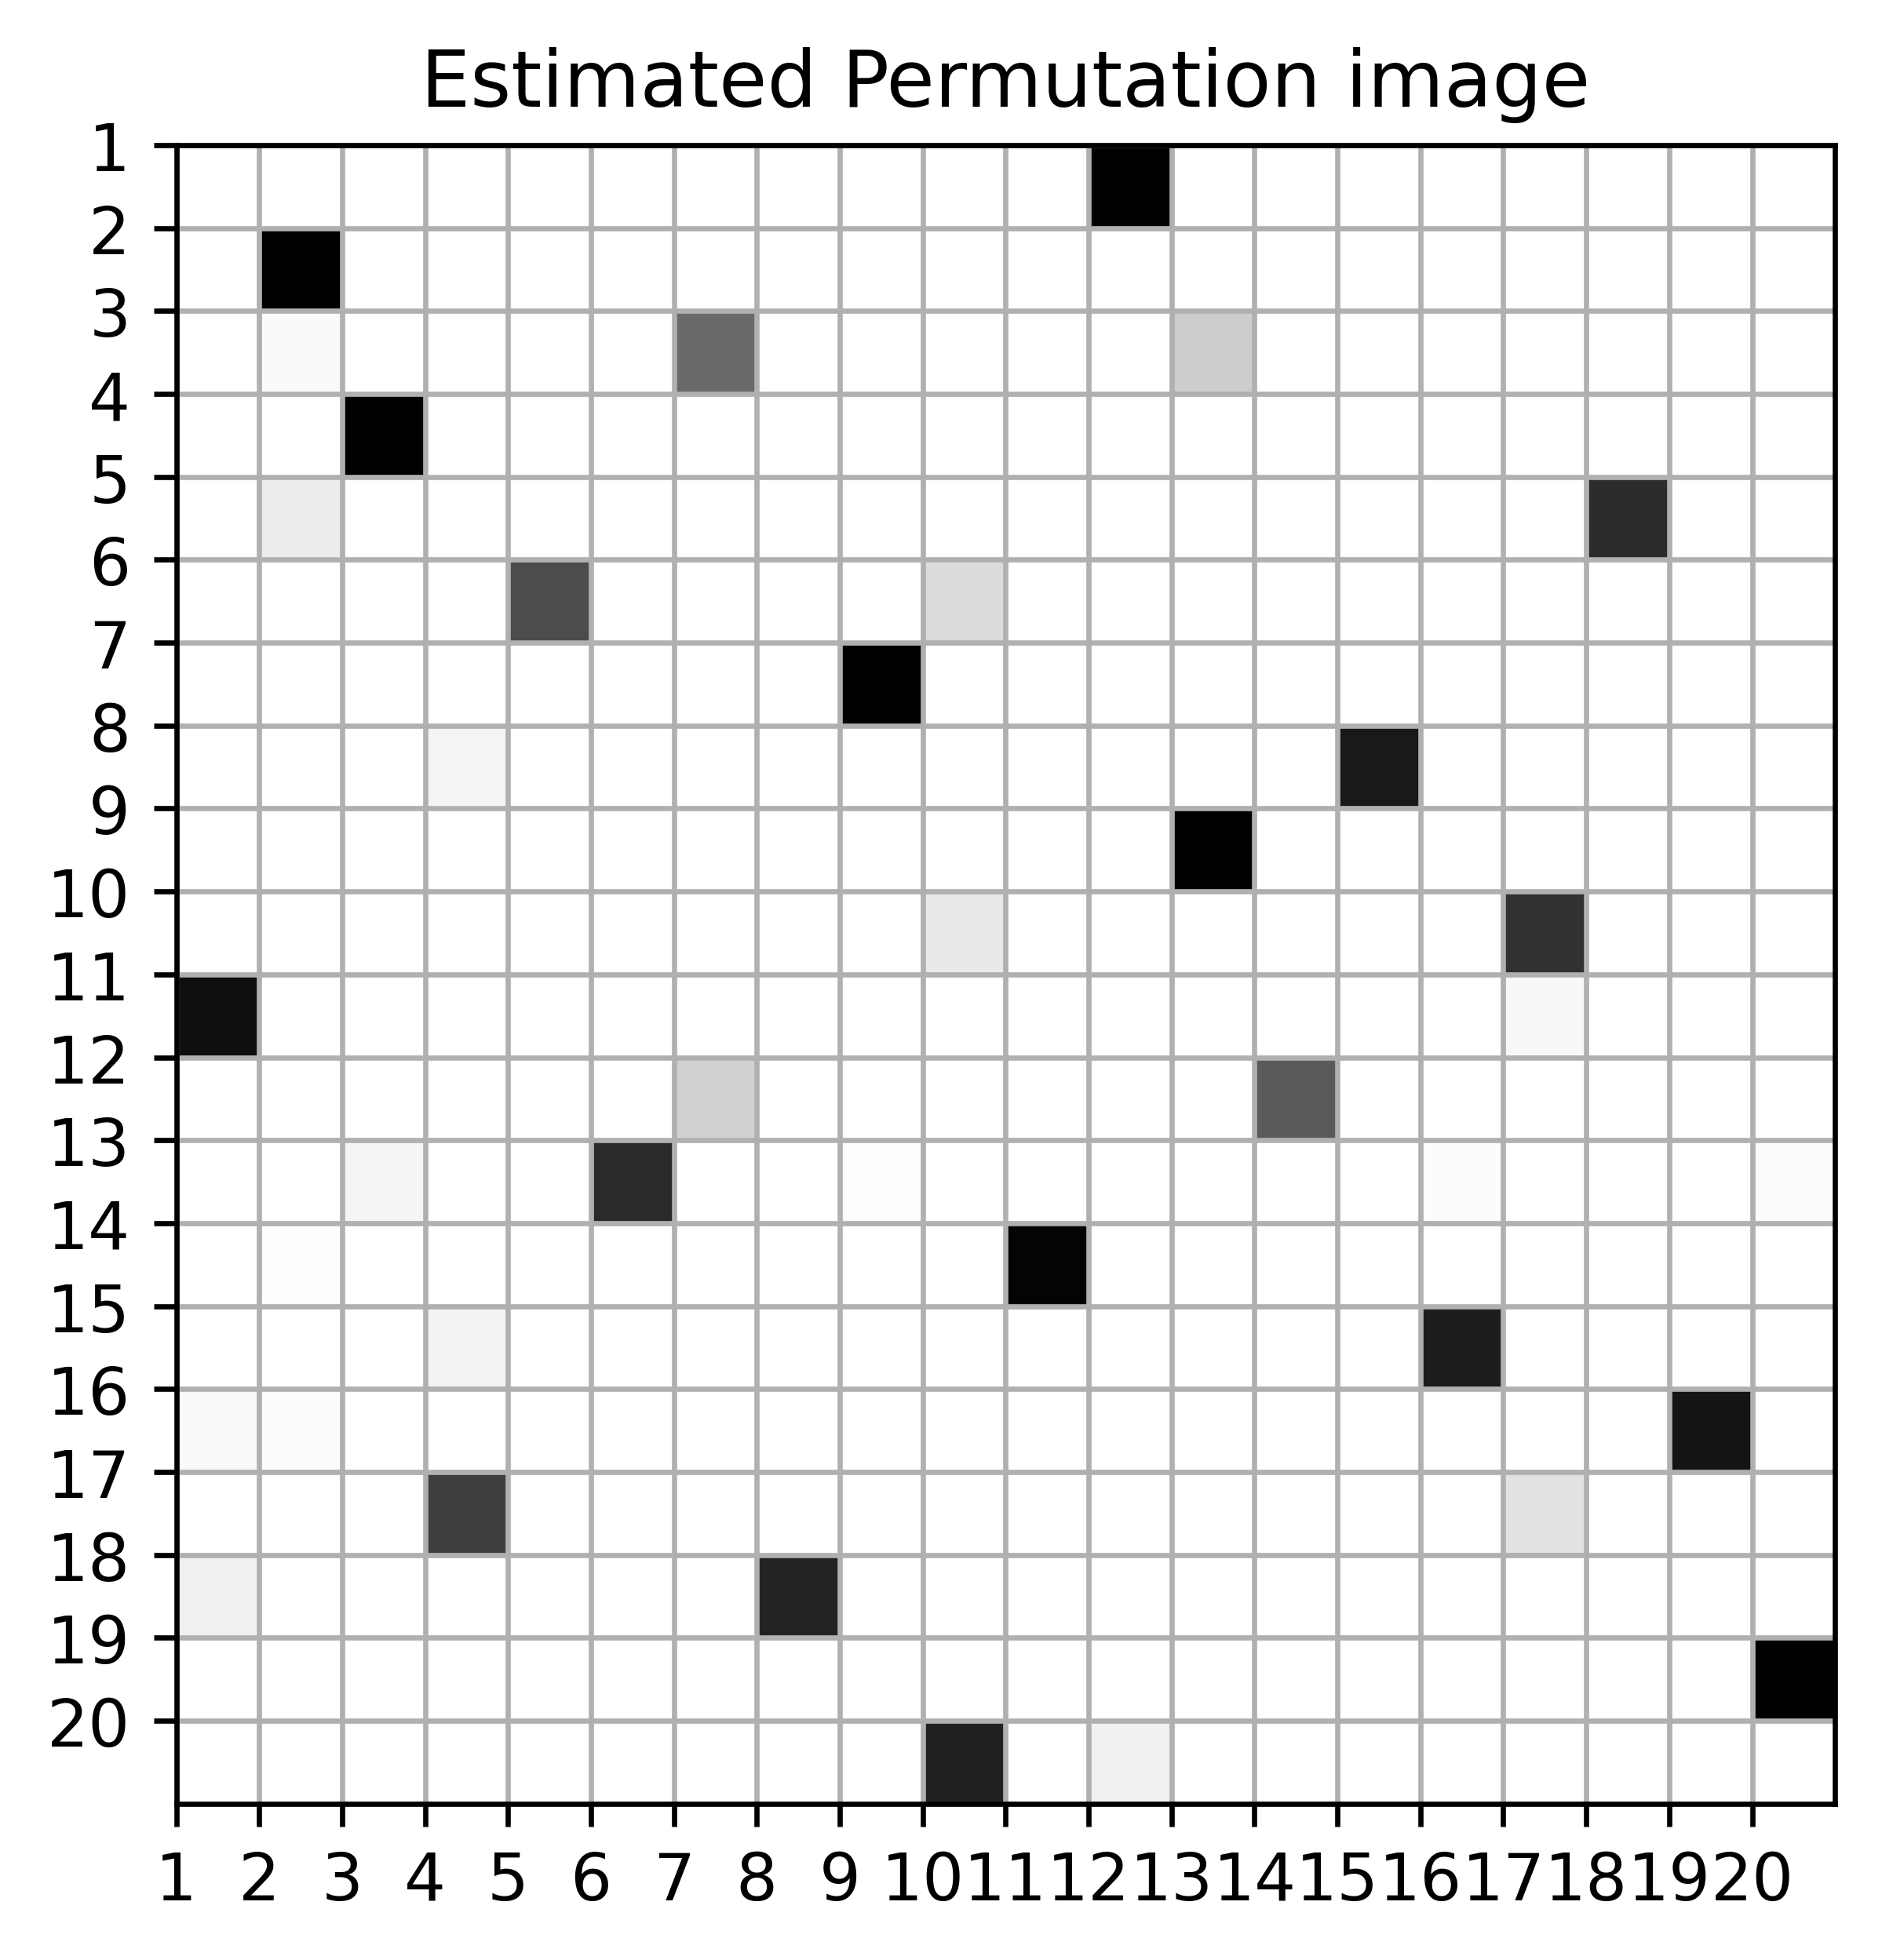

In [ ]:
import torchvision.transforms as transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

plt.imsave("true_PI.png", true_PI, cmap='Greys')
# load and show the True permutation
fig, ax = plt.subplots(figsize=(10,10),dpi=600)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
    ax.spines[axis].set_color("black")
    ax.spines[axis].set_zorder(0)
a = plt.imread("true_PI.png")
K_ = [-0.5+i for i in range(20)]
idx = [i+1 for i in range(20)]
plt.subplot(1,2,1)
plt.imshow(a)
plt.title("true Permutation image")
plt.xticks(K_, idx)
plt.yticks(K_, idx)
plt.grid(True)

for esti_PI in esti_PI_list:
    plt.imsave("esti_PI.png", esti_PI, cmap='Greys')
    fig, ax = plt.subplots(figsize=(10,10),dpi=600)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
        ax.spines[axis].set_color("black")
        ax.spines[axis].set_zorder(0)
    # load and show the Estimate permutation
    a = plt.imread("esti_PI.png")
    plt.subplot(1,2,2)
    plt.imshow(a)
    plt.title("Estimated Permutation image")
    plt.xticks(K_, idx)
    plt.yticks(K_, idx)
    plt.grid(True)